Processing files with parameters: type=act, img=beta, mask=VSconstrained, denoise=base
Data saved to multiecho_data_act_beta_VSconstrained_base.csv
Found data for 40 subjects

Sample of the data:
    subject  headcoil      mb1me1      mb3me1      mb6me1      mb1me4  \
15    10017        64   -4.671750   94.225272 -104.142611 -162.286756   
14    10024        64  108.144702  171.678553  -71.579402  194.614259   
6     10035        64  177.945209   31.420981  -54.147004  346.247572   
38    10041        64  -49.422607  139.081973   60.893990  199.377341   
35    10043        64   40.083598  171.309089  261.922597  522.679206   

        mb3me4      mb6me4  
15   99.403756  -85.024436  
14  373.619278  223.327079  
6  -154.840010   11.494569  
38   85.674422  407.643753  
35  311.496890  234.641249  

Headcoil counts:
64-channel: 23
20-channel: 17

Creating bar plots...
Plot saved as 'multiecho_plots_act_beta_VSconstrained_base.png'


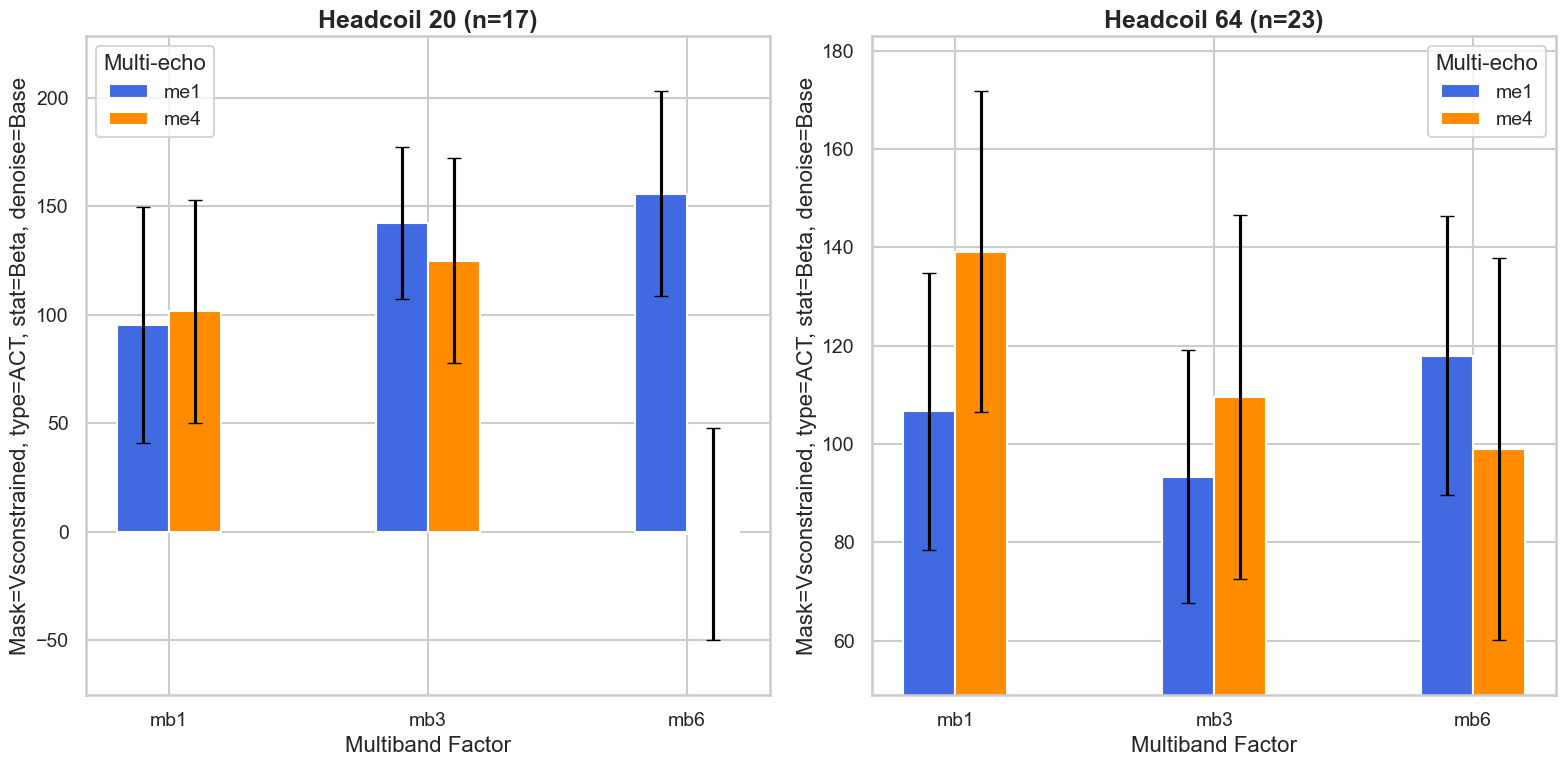

In [9]:
# VS Act, Rew>Pun, Beta
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

# Parameters that can be changed to repurpose the script
# Change these values to match the files you want to process
TYPE_VALUE = "act"  # e.g., "act"
IMG_VALUE = "beta"  # e.g., "beta"
MASK_VALUE = "VSconstrained"   # e.g., "VS"
DENOISE_VALUE = "base"  # e.g., "base"

# Path to the directory containing the text files
BASE_DIR = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/extractions")

# List of all expected acquisition parameters
ACQ_PARAMS = ["mb1me1", "mb3me1", "mb6me1", "mb1me4", "mb3me4", "mb6me4"]

# Subjects with headcoil value of 64 (all others will be 20)
HEADCOIL_64_SUBJECTS = [
    "10015", "10017", "10024", "10028", "10035", "10041", "10043", "10046", 
    "10054", "10059", "10069", "10074", "10078", "10080", "10085", "10094", 
    "10108", "10125", "10130", "10136", "10137", "10142", "10150", "10154", 
    "10186", "10188", "10221"
]

def extract_file_data():
    # Pattern to match filenames and extract parameters
    pattern = re.compile(
        r"ts_sub-(\d+)_acq_([^_]+)_type-([^_]+)_img-([^_]+)_mask-([^_]+)_denoise_([^\.]+)\.txt"
    )
    
    # Dictionary to store data by subject
    data_by_subject = {}
    
    # Find all text files in the directory
    file_paths = glob.glob(os.path.join(BASE_DIR, "*.txt"))
    
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        match = pattern.match(filename)
        
        if match:
            sub_id, acq, file_type, img, mask, denoise = match.groups()
            
            # Skip subjects with 'sp' in their ID
            if 'sp' in sub_id:
                continue
                
            # Check if this file matches our target parameters
            if (file_type == TYPE_VALUE and img == IMG_VALUE 
                and mask == MASK_VALUE and denoise == DENOISE_VALUE):
                
                # Read the value from the file
                try:
                    with open(file_path, 'r') as f:
                        value = float(f.read().strip())
                        
                    # Initialize subject data if not already present
                    if sub_id not in data_by_subject:
                        data_by_subject[sub_id] = {acq_param: np.nan for acq_param in ACQ_PARAMS}
                    
                    # Store the value
                    data_by_subject[sub_id][acq] = value
                    
                except (ValueError, IOError) as e:
                    print(f"Error processing file {filename}: {e}")
    
    return data_by_subject

def create_dataframe(data_by_subject):
    # Create a DataFrame from the collected data
    df = pd.DataFrame.from_dict(data_by_subject, orient='index')
    
    # Reset index to make subject ID a column and rename it
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'subject'}, inplace=True)
    
    # Add headcoil column
    df['headcoil'] = df['subject'].apply(lambda x: 64 if x in HEADCOIL_64_SUBJECTS else 20)
    
    # Reorder columns to ensure correct order (subject, headcoil, then acquisition parameters)
    column_order = ['subject', 'headcoil'] + ACQ_PARAMS
    df = df[column_order]
    
    # Sort by subject ID (as integers)
    df['subject'] = df['subject'].astype(int)
    df.sort_values('subject', inplace=True)
    
    return df

# Function to prepare data for plotting
def prepare_plot_data(df):
    # Split by headcoil type
    df_20 = df[df['headcoil'] == 20]
    df_64 = df[df['headcoil'] == 64]
    
    results = {}
    
    for hc_name, hc_df in [('20', df_20), ('64', df_64)]:
        # Calculate means and standard errors for each acquisition
        means = {}
        errors = {}
        
        for acq in ACQ_PARAMS:
            means[acq] = hc_df[acq].mean()
            errors[acq] = hc_df[acq].sem()  # Standard error of the mean
        
        results[hc_name] = {
            'means': means,
            'errors': errors,
            'count': len(hc_df)
        }
    
    return results

# Function to create the bar plots
def create_bar_plots(plot_data):
    # Set up figure and font sizes
    plt.rcParams.update({'font.size': 14})  # Increase base font size
    
    # Set up the figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Set style
    sns.set_style("whitegrid")
    sns.set_context("talk")  # Larger context for bigger fonts
    
    # Define the x positions for the bars - make them closer together
    width = 0.4  # Increased width for thicker bars
    
    # Colors
    me1_color = 'royalblue'
    me4_color = 'darkorange'
    
    # Separate the means and errors for easier plotting
    for i, (hc, ax, title) in enumerate([('20', ax1, 'Headcoil 20'), ('64', ax2, 'Headcoil 64')]):
        data = plot_data[hc]
        means = data['means']
        errors = data['errors']
        count = data['count']
        
        # Create two sets of bars (me1 and me4)
        me1_means = [means['mb1me1'], means['mb3me1'], means['mb6me1']]
        me1_errors = [errors['mb1me1'], errors['mb3me1'], errors['mb6me1']]
        
        me4_means = [means['mb1me4'], means['mb3me4'], means['mb6me4']]
        me4_errors = [errors['mb1me4'], errors['mb3me4'], errors['mb6me4']]
        
        # Update x positions to have bars touching
        x1 = [0, 2, 4]  # Positions for me1 bars
        x2 = [0+width, 2+width, 4+width]  # Positions for me4 bars
        
        # Plot the bars
        ax.bar(x1, me1_means, width, color=me1_color, label='me1', yerr=me1_errors, capsize=5)
        ax.bar(x2, me4_means, width, color=me4_color, label='me4', yerr=me4_errors, capsize=5)
        
        # Set labels and title with increased font size
        # Generate dynamic Y-axis label
        y_label = f"Mask={MASK_VALUE.capitalize()}, type={TYPE_VALUE.upper()}, stat={IMG_VALUE.capitalize()}, denoise={DENOISE_VALUE.capitalize()}"
        ax.set_ylabel(y_label, fontsize=16)
        ax.set_title(f"{title} (n={count})", fontsize=18, fontweight='bold')
        
        # Set x-axis ticks and labels
        ax.set_xticks([width/2, 2+width/2, 4+width/2])  # Center ticks between each pair of bars
        ax.set_xticklabels(['mb1', 'mb3', 'mb6'], fontsize=16)
        ax.set_xlabel('Multiband Factor', fontsize=16)
        
        # Increase tick label font size
        ax.tick_params(axis='both', which='major', labelsize=14)
        
        # Add a legend with increased font size
        legend = ax.legend(['me1', 'me4'], title='Multi-echo', fontsize=14)
        legend.get_title().set_fontsize(16)
        
        # Set y-limit to start slightly below the minimum value
        y_values = me1_means + me4_means
        y_errors = me1_errors + me4_errors
        
        y_min = min([v-e for v, e in zip(y_values, y_errors)])
        y_max = max([v+e for v, e in zip(y_values, y_errors)])
        
        margin = (y_max - y_min) * 0.1
        ax.set_ylim(y_min - margin, y_max + margin)
    
    plt.tight_layout()
    return fig

def process_and_visualize():
    print(f"Processing files with parameters: type={TYPE_VALUE}, img={IMG_VALUE}, mask={MASK_VALUE}, denoise={DENOISE_VALUE}")
    
    # Extract data from files
    data_by_subject = extract_file_data()
    
    if not data_by_subject:
        print("No matching files found.")
        return
    
    # Create DataFrame
    df = create_dataframe(data_by_subject)
    
    # Save to CSV
    output_file = f"multiecho_data_{TYPE_VALUE}_{IMG_VALUE}_{MASK_VALUE}_{DENOISE_VALUE}.csv"
    df.to_csv(output_file, index=False)
    
    print(f"Data saved to {output_file}")
    print(f"Found data for {len(df)} subjects")
    
    # Display the first few rows
    print("\nSample of the data:")
    print(df.head())
    
    # Count headcoil types
    headcoil_counts = df['headcoil'].value_counts()
    print("\nHeadcoil counts:")
    print(f"64-channel: {headcoil_counts.get(64, 0)}")
    print(f"20-channel: {headcoil_counts.get(20, 0)}")
    
    # Prepare data for plotting
    plot_data = prepare_plot_data(df)
    
    # Create and save bar plots
    print("\nCreating bar plots...")
    fig = create_bar_plots(plot_data)
    
    # Save the plot
    plot_file = f"multiecho_plots_{TYPE_VALUE}_{IMG_VALUE}_{MASK_VALUE}_{DENOISE_VALUE}.png"
    plt.savefig(plot_file, dpi=300, bbox_inches='tight')
    
    print(f"Plot saved as '{plot_file}'")
    
    return df, fig

if __name__ == "__main__":
    df, fig = process_and_visualize()

In [ ]:
# VS Act, Rew>Pun, zstat
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

# Parameters that can be changed to repurpose the script
# Change these values to match the files you want to process
TYPE_VALUE = "act"  # e.g., "act"
IMG_VALUE = "zstat"  # e.g., "beta"
MASK_VALUE = "VS"   # e.g., "VS"
DENOISE_VALUE = "base"  # e.g., "base"

# Path to the directory containing the text files
BASE_DIR = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/extractions")

# List of all expected acquisition parameters
ACQ_PARAMS = ["mb1me1", "mb3me1", "mb6me1", "mb1me4", "mb3me4", "mb6me4"]

# Subjects with headcoil value of 64 (all others will be 20)
HEADCOIL_64_SUBJECTS = [
    "10015", "10017", "10024", "10028", "10035", "10041", "10043", "10046", 
    "10054", "10059", "10069", "10074", "10078", "10080", "10085", "10094", 
    "10108", "10125", "10130", "10136", "10137", "10142", "10150", "10154", 
    "10186", "10188", "10221"
]

def extract_file_data():
    # Pattern to match filenames and extract parameters
    pattern = re.compile(
        r"ts_sub-(\d+)_acq_([^_]+)_type-([^_]+)_img-([^_]+)_mask-([^_]+)_denoise_([^\.]+)\.txt"
    )
    
    # Dictionary to store data by subject
    data_by_subject = {}
    
    # Find all text files in the directory
    file_paths = glob.glob(os.path.join(BASE_DIR, "*.txt"))
    
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        match = pattern.match(filename)
        
        if match:
            sub_id, acq, file_type, img, mask, denoise = match.groups()
            
            # Skip subjects with 'sp' in their ID
            if 'sp' in sub_id:
                continue
                
            # Check if this file matches our target parameters
            if (file_type == TYPE_VALUE and img == IMG_VALUE 
                and mask == MASK_VALUE and denoise == DENOISE_VALUE):
                
                # Read the value from the file
                try:
                    with open(file_path, 'r') as f:
                        value = float(f.read().strip())
                        
                    # Initialize subject data if not already present
                    if sub_id not in data_by_subject:
                        data_by_subject[sub_id] = {acq_param: np.nan for acq_param in ACQ_PARAMS}
                    
                    # Store the value
                    data_by_subject[sub_id][acq] = value
                    
                except (ValueError, IOError) as e:
                    print(f"Error processing file {filename}: {e}")
    
    return data_by_subject

def create_dataframe(data_by_subject):
    # Create a DataFrame from the collected data
    df = pd.DataFrame.from_dict(data_by_subject, orient='index')
    
    # Reset index to make subject ID a column and rename it
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'subject'}, inplace=True)
    
    # Add headcoil column
    df['headcoil'] = df['subject'].apply(lambda x: 64 if x in HEADCOIL_64_SUBJECTS else 20)
    
    # Reorder columns to ensure correct order (subject, headcoil, then acquisition parameters)
    column_order = ['subject', 'headcoil'] + ACQ_PARAMS
    df = df[column_order]
    
    # Sort by subject ID (as integers)
    df['subject'] = df['subject'].astype(int)
    df.sort_values('subject', inplace=True)
    
    return df

# Function to prepare data for plotting
def prepare_plot_data(df):
    # Split by headcoil type
    df_20 = df[df['headcoil'] == 20]
    df_64 = df[df['headcoil'] == 64]
    
    results = {}
    
    for hc_name, hc_df in [('20', df_20), ('64', df_64)]:
        # Calculate means and standard errors for each acquisition
        means = {}
        errors = {}
        
        for acq in ACQ_PARAMS:
            means[acq] = hc_df[acq].mean()
            errors[acq] = hc_df[acq].sem()  # Standard error of the mean
        
        results[hc_name] = {
            'means': means,
            'errors': errors,
            'count': len(hc_df)
        }
    
    return results

# Function to create the bar plots
def create_bar_plots(plot_data):
    # Set up figure and font sizes
    plt.rcParams.update({'font.size': 14})  # Increase base font size
    
    # Set up the figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Set style
    sns.set_style("whitegrid")
    sns.set_context("talk")  # Larger context for bigger fonts
    
    # Define the x positions for the bars - make them closer together
    width = 0.4  # Increased width for thicker bars
    
    # Colors
    me1_color = 'royalblue'
    me4_color = 'darkorange'
    
    # Separate the means and errors for easier plotting
    for i, (hc, ax, title) in enumerate([('20', ax1, 'Headcoil 20'), ('64', ax2, 'Headcoil 64')]):
        data = plot_data[hc]
        means = data['means']
        errors = data['errors']
        count = data['count']
        
        # Create two sets of bars (me1 and me4)
        me1_means = [means['mb1me1'], means['mb3me1'], means['mb6me1']]
        me1_errors = [errors['mb1me1'], errors['mb3me1'], errors['mb6me1']]
        
        me4_means = [means['mb1me4'], means['mb3me4'], means['mb6me4']]
        me4_errors = [errors['mb1me4'], errors['mb3me4'], errors['mb6me4']]
        
        # Update x positions to have bars touching
        x1 = [0, 2, 4]  # Positions for me1 bars
        x2 = [0+width, 2+width, 4+width]  # Positions for me4 bars
        
        # Plot the bars
        ax.bar(x1, me1_means, width, color=me1_color, label='me1', yerr=me1_errors, capsize=5)
        ax.bar(x2, me4_means, width, color=me4_color, label='me4', yerr=me4_errors, capsize=5)
        
        # Set labels and title with increased font size
        ax.set_ylabel('VS Act, Rew>Pun (zstat)', fontsize=16)
        ax.set_title(f"{title} (n={count})", fontsize=18, fontweight='bold')
        
        # Set x-axis ticks and labels
        ax.set_xticks([width/2, 2+width/2, 4+width/2])  # Center ticks between each pair of bars
        ax.set_xticklabels(['mb1', 'mb3', 'mb6'], fontsize=16)
        ax.set_xlabel('Multiband Factor', fontsize=16)
        
        # Increase tick label font size
        ax.tick_params(axis='both', which='major', labelsize=14)
        
        # Add a legend with increased font size
        legend = ax.legend(['me1', 'me4'], title='Multi-echo', fontsize=14)
        legend.get_title().set_fontsize(16)
        
        # Set y-limit to start slightly below the minimum value
        y_values = me1_means + me4_means
        y_errors = me1_errors + me4_errors
        
        y_min = min([v-e for v, e in zip(y_values, y_errors)])
        y_max = max([v+e for v, e in zip(y_values, y_errors)])
        
        margin = (y_max - y_min) * 0.1
        ax.set_ylim(y_min - margin, y_max + margin)
    
    plt.tight_layout()
    return fig

def process_and_visualize():
    print(f"Processing files with parameters: type={TYPE_VALUE}, img={IMG_VALUE}, mask={MASK_VALUE}, denoise={DENOISE_VALUE}")
    
    # Extract data from files
    data_by_subject = extract_file_data()
    
    if not data_by_subject:
        print("No matching files found.")
        return
    
    # Create DataFrame
    df = create_dataframe(data_by_subject)
    
    # Save to CSV
    output_file = f"multiecho_data_{TYPE_VALUE}_{IMG_VALUE}_{MASK_VALUE}_{DENOISE_VALUE}.csv"
    df.to_csv(output_file, index=False)
    
    print(f"Data saved to {output_file}")
    print(f"Found data for {len(df)} subjects")
    
    # Display the first few rows
    print("\nSample of the data:")
    print(df.head())
    
    # Count headcoil types
    headcoil_counts = df['headcoil'].value_counts()
    print("\nHeadcoil counts:")
    print(f"64-channel: {headcoil_counts.get(64, 0)}")
    print(f"20-channel: {headcoil_counts.get(20, 0)}")
    
    # Prepare data for plotting
    plot_data = prepare_plot_data(df)
    
    # Create and save bar plots
    print("\nCreating bar plots...")
    fig = create_bar_plots(plot_data)
    
    # Save the plot
    plot_file = f"multiecho_plots_{TYPE_VALUE}_{IMG_VALUE}_{MASK_VALUE}_{DENOISE_VALUE}.png"
    plt.savefig(plot_file, dpi=300, bbox_inches='tight')
    
    print(f"Plot saved as '{plot_file}'")
    
    return df, fig

if __name__ == "__main__":
    df, fig = process_and_visualize()

In [ ]:
# VS TSNR, Rew>Pun
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

# Parameters that can be changed to repurpose the script
# Change these values to match the files you want to process
TYPE_VALUE = "act"  # e.g., "act"
IMG_VALUE = "tsnr"  # e.g., "beta"
MASK_VALUE = "VS"   # e.g., "VS"
DENOISE_VALUE = "base"  # e.g., "base"

# Path to the directory containing the text files
BASE_DIR = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/extractions")

# List of all expected acquisition parameters
ACQ_PARAMS = ["mb1me1", "mb3me1", "mb6me1", "mb1me4", "mb3me4", "mb6me4"]

# Subjects with headcoil value of 64 (all others will be 20)
HEADCOIL_64_SUBJECTS = [
    "10015", "10017", "10024", "10028", "10035", "10041", "10043", "10046", 
    "10054", "10059", "10069", "10074", "10078", "10080", "10085", "10094", 
    "10108", "10125", "10130", "10136", "10137", "10142", "10150", "10154", 
    "10186", "10188", "10221"
]

def extract_file_data():
    # Pattern to match filenames and extract parameters
    pattern = re.compile(
        r"ts_sub-(\d+)_acq_([^_]+)_type-([^_]+)_img-([^_]+)_mask-([^_]+)_denoise_([^\.]+)\.txt"
    )
    
    # Dictionary to store data by subject
    data_by_subject = {}
    
    # Find all text files in the directory
    file_paths = glob.glob(os.path.join(BASE_DIR, "*.txt"))
    
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        match = pattern.match(filename)
        
        if match:
            sub_id, acq, file_type, img, mask, denoise = match.groups()
            
            # Skip subjects with 'sp' in their ID
            if 'sp' in sub_id:
                continue
                
            # Check if this file matches our target parameters
            if (file_type == TYPE_VALUE and img == IMG_VALUE 
                and mask == MASK_VALUE and denoise == DENOISE_VALUE):
                
                # Read the value from the file
                try:
                    with open(file_path, 'r') as f:
                        value = float(f.read().strip())
                        
                    # Initialize subject data if not already present
                    if sub_id not in data_by_subject:
                        data_by_subject[sub_id] = {acq_param: np.nan for acq_param in ACQ_PARAMS}
                    
                    # Store the value
                    data_by_subject[sub_id][acq] = value
                    
                except (ValueError, IOError) as e:
                    print(f"Error processing file {filename}: {e}")
    
    return data_by_subject

def create_dataframe(data_by_subject):
    # Create a DataFrame from the collected data
    df = pd.DataFrame.from_dict(data_by_subject, orient='index')
    
    # Reset index to make subject ID a column and rename it
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'subject'}, inplace=True)
    
    # Add headcoil column
    df['headcoil'] = df['subject'].apply(lambda x: 64 if x in HEADCOIL_64_SUBJECTS else 20)
    
    # Reorder columns to ensure correct order (subject, headcoil, then acquisition parameters)
    column_order = ['subject', 'headcoil'] + ACQ_PARAMS
    df = df[column_order]
    
    # Sort by subject ID (as integers)
    df['subject'] = df['subject'].astype(int)
    df.sort_values('subject', inplace=True)
    
    return df

# Function to prepare data for plotting
def prepare_plot_data(df):
    # Split by headcoil type
    df_20 = df[df['headcoil'] == 20]
    df_64 = df[df['headcoil'] == 64]
    
    results = {}
    
    for hc_name, hc_df in [('20', df_20), ('64', df_64)]:
        # Calculate means and standard errors for each acquisition
        means = {}
        errors = {}
        
        for acq in ACQ_PARAMS:
            means[acq] = hc_df[acq].mean()
            errors[acq] = hc_df[acq].sem()  # Standard error of the mean
        
        results[hc_name] = {
            'means': means,
            'errors': errors,
            'count': len(hc_df)
        }
    
    return results

# Function to create the bar plots
def create_bar_plots(plot_data):
    # Set up figure and font sizes
    plt.rcParams.update({'font.size': 14})  # Increase base font size
    
    # Set up the figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Set style
    sns.set_style("whitegrid")
    sns.set_context("talk")  # Larger context for bigger fonts
    
    # Define the x positions for the bars - make them closer together
    width = 0.4  # Increased width for thicker bars
    
    # Colors
    me1_color = 'royalblue'
    me4_color = 'darkorange'
    
    # Separate the means and errors for easier plotting
    for i, (hc, ax, title) in enumerate([('20', ax1, 'Headcoil 20'), ('64', ax2, 'Headcoil 64')]):
        data = plot_data[hc]
        means = data['means']
        errors = data['errors']
        count = data['count']
        
        # Create two sets of bars (me1 and me4)
        me1_means = [means['mb1me1'], means['mb3me1'], means['mb6me1']]
        me1_errors = [errors['mb1me1'], errors['mb3me1'], errors['mb6me1']]
        
        me4_means = [means['mb1me4'], means['mb3me4'], means['mb6me4']]
        me4_errors = [errors['mb1me4'], errors['mb3me4'], errors['mb6me4']]
        
        # Update x positions to have bars touching
        x1 = [0, 2, 4]  # Positions for me1 bars
        x2 = [0+width, 2+width, 4+width]  # Positions for me4 bars
        
        # Plot the bars
        ax.bar(x1, me1_means, width, color=me1_color, label='me1', yerr=me1_errors, capsize=5)
        ax.bar(x2, me4_means, width, color=me4_color, label='me4', yerr=me4_errors, capsize=5)
        
        # Set labels and title with increased font size
        ax.set_ylabel('VS TSNR, Rew>Pun', fontsize=16)
        ax.set_title(f"{title} (n={count})", fontsize=18, fontweight='bold')
        
        # Set x-axis ticks and labels
        ax.set_xticks([width/2, 2+width/2, 4+width/2])  # Center ticks between each pair of bars
        ax.set_xticklabels(['mb1', 'mb3', 'mb6'], fontsize=16)
        ax.set_xlabel('Multiband Factor', fontsize=16)
        
        # Increase tick label font size
        ax.tick_params(axis='both', which='major', labelsize=14)
        
        # Add a legend with increased font size
        legend = ax.legend(['me1', 'me4'], title='Multi-echo', fontsize=14)
        legend.get_title().set_fontsize(16)
        
        # Set y-limit to start slightly below the minimum value
        y_values = me1_means + me4_means
        y_errors = me1_errors + me4_errors
        
        y_min = min([v-e for v, e in zip(y_values, y_errors)])
        y_max = max([v+e for v, e in zip(y_values, y_errors)])
        
        margin = (y_max - y_min) * 0.1
        ax.set_ylim(y_min - margin, y_max + margin)
    
    plt.tight_layout()
    return fig

def process_and_visualize():
    print(f"Processing files with parameters: type={TYPE_VALUE}, img={IMG_VALUE}, mask={MASK_VALUE}, denoise={DENOISE_VALUE}")
    
    # Extract data from files
    data_by_subject = extract_file_data()
    
    if not data_by_subject:
        print("No matching files found.")
        return
    
    # Create DataFrame
    df = create_dataframe(data_by_subject)
    
    # Save to CSV
    output_file = f"multiecho_data_{TYPE_VALUE}_{IMG_VALUE}_{MASK_VALUE}_{DENOISE_VALUE}.csv"
    df.to_csv(output_file, index=False)
    
    print(f"Data saved to {output_file}")
    print(f"Found data for {len(df)} subjects")
    
    # Display the first few rows
    print("\nSample of the data:")
    print(df.head())
    
    # Count headcoil types
    headcoil_counts = df['headcoil'].value_counts()
    print("\nHeadcoil counts:")
    print(f"64-channel: {headcoil_counts.get(64, 0)}")
    print(f"20-channel: {headcoil_counts.get(20, 0)}")
    
    # Prepare data for plotting
    plot_data = prepare_plot_data(df)
    
    # Create and save bar plots
    print("\nCreating bar plots...")
    fig = create_bar_plots(plot_data)
    
    # Save the plot
    plot_file = f"multiecho_plots_{TYPE_VALUE}_{IMG_VALUE}_{MASK_VALUE}_{DENOISE_VALUE}.png"
    plt.savefig(plot_file, dpi=300, bbox_inches='tight')
    
    print(f"Plot saved as '{plot_file}'")
    
    return df, fig

if __name__ == "__main__":
    df, fig = process_and_visualize()

In [ ]:
# VMPFC TSNR
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

# Parameters that can be changed to repurpose the script
# Change these values to match the files you want to process
TYPE_VALUE = "act"  # e.g., "act"
IMG_VALUE = "tsnr"  # e.g., "beta"
MASK_VALUE = "VMPFC"   # e.g., "VS"
DENOISE_VALUE = "base"  # e.g., "base"

# Path to the directory containing the text files
BASE_DIR = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/extractions")

# List of all expected acquisition parameters
ACQ_PARAMS = ["mb1me1", "mb3me1", "mb6me1", "mb1me4", "mb3me4", "mb6me4"]

# Subjects with headcoil value of 64 (all others will be 20)
HEADCOIL_64_SUBJECTS = [
    "10015", "10017", "10024", "10028", "10035", "10041", "10043", "10046", 
    "10054", "10059", "10069", "10074", "10078", "10080", "10085", "10094", 
    "10108", "10125", "10130", "10136", "10137", "10142", "10150", "10154", 
    "10186", "10188", "10221"
]

def extract_file_data():
    # Pattern to match filenames and extract parameters
    pattern = re.compile(
        r"ts_sub-(\d+)_acq_([^_]+)_type-([^_]+)_img-([^_]+)_mask-([^_]+)_denoise_([^\.]+)\.txt"
    )
    
    # Dictionary to store data by subject
    data_by_subject = {}
    
    # Find all text files in the directory
    file_paths = glob.glob(os.path.join(BASE_DIR, "*.txt"))
    
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        match = pattern.match(filename)
        
        if match:
            sub_id, acq, file_type, img, mask, denoise = match.groups()
            
            # Skip subjects with 'sp' in their ID
            if 'sp' in sub_id:
                continue
                
            # Check if this file matches our target parameters
            if (file_type == TYPE_VALUE and img == IMG_VALUE 
                and mask == MASK_VALUE and denoise == DENOISE_VALUE):
                
                # Read the value from the file
                try:
                    with open(file_path, 'r') as f:
                        value = float(f.read().strip())
                        
                    # Initialize subject data if not already present
                    if sub_id not in data_by_subject:
                        data_by_subject[sub_id] = {acq_param: np.nan for acq_param in ACQ_PARAMS}
                    
                    # Store the value
                    data_by_subject[sub_id][acq] = value
                    
                except (ValueError, IOError) as e:
                    print(f"Error processing file {filename}: {e}")
    
    return data_by_subject

def create_dataframe(data_by_subject):
    # Create a DataFrame from the collected data
    df = pd.DataFrame.from_dict(data_by_subject, orient='index')
    
    # Reset index to make subject ID a column and rename it
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'subject'}, inplace=True)
    
    # Add headcoil column
    df['headcoil'] = df['subject'].apply(lambda x: 64 if x in HEADCOIL_64_SUBJECTS else 20)
    
    # Reorder columns to ensure correct order (subject, headcoil, then acquisition parameters)
    column_order = ['subject', 'headcoil'] + ACQ_PARAMS
    df = df[column_order]
    
    # Sort by subject ID (as integers)
    df['subject'] = df['subject'].astype(int)
    df.sort_values('subject', inplace=True)
    
    return df

# Function to prepare data for plotting
def prepare_plot_data(df):
    # Split by headcoil type
    df_20 = df[df['headcoil'] == 20]
    df_64 = df[df['headcoil'] == 64]
    
    results = {}
    
    for hc_name, hc_df in [('20', df_20), ('64', df_64)]:
        # Calculate means and standard errors for each acquisition
        means = {}
        errors = {}
        
        for acq in ACQ_PARAMS:
            means[acq] = hc_df[acq].mean()
            errors[acq] = hc_df[acq].sem()  # Standard error of the mean
        
        results[hc_name] = {
            'means': means,
            'errors': errors,
            'count': len(hc_df)
        }
    
    return results

# Function to create the bar plots
def create_bar_plots(plot_data):
    # Set up figure and font sizes
    plt.rcParams.update({'font.size': 14})  # Increase base font size
    
    # Set up the figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Set style
    sns.set_style("whitegrid")
    sns.set_context("talk")  # Larger context for bigger fonts
    
    # Define the x positions for the bars - make them closer together
    width = 0.4  # Increased width for thicker bars
    
    # Colors
    me1_color = 'royalblue'
    me4_color = 'darkorange'
    
    # Separate the means and errors for easier plotting
    for i, (hc, ax, title) in enumerate([('20', ax1, 'Headcoil 20'), ('64', ax2, 'Headcoil 64')]):
        data = plot_data[hc]
        means = data['means']
        errors = data['errors']
        count = data['count']
        
        # Create two sets of bars (me1 and me4)
        me1_means = [means['mb1me1'], means['mb3me1'], means['mb6me1']]
        me1_errors = [errors['mb1me1'], errors['mb3me1'], errors['mb6me1']]
        
        me4_means = [means['mb1me4'], means['mb3me4'], means['mb6me4']]
        me4_errors = [errors['mb1me4'], errors['mb3me4'], errors['mb6me4']]
        
        # Update x positions to have bars touching
        x1 = [0, 2, 4]  # Positions for me1 bars
        x2 = [0+width, 2+width, 4+width]  # Positions for me4 bars
        
        # Plot the bars
        ax.bar(x1, me1_means, width, color=me1_color, label='me1', yerr=me1_errors, capsize=5)
        ax.bar(x2, me4_means, width, color=me4_color, label='me4', yerr=me4_errors, capsize=5)
        
        # Set labels and title with increased font size
        ax.set_ylabel('VMPFC TSNR, Rew>Pun', fontsize=16)
        ax.set_title(f"{title} (n={count})", fontsize=18, fontweight='bold')
        
        # Set x-axis ticks and labels
        ax.set_xticks([width/2, 2+width/2, 4+width/2])  # Center ticks between each pair of bars
        ax.set_xticklabels(['mb1', 'mb3', 'mb6'], fontsize=16)
        ax.set_xlabel('Multiband Factor', fontsize=16)
        
        # Increase tick label font size
        ax.tick_params(axis='both', which='major', labelsize=14)
        
        # Add a legend with increased font size
        legend = ax.legend(['me1', 'me4'], title='Multi-echo', fontsize=14)
        legend.get_title().set_fontsize(16)
        
        # Set y-limit to start slightly below the minimum value
        y_values = me1_means + me4_means
        y_errors = me1_errors + me4_errors
        
        y_min = min([v-e for v, e in zip(y_values, y_errors)])
        y_max = max([v+e for v, e in zip(y_values, y_errors)])
        
        margin = (y_max - y_min) * 0.1
        ax.set_ylim(y_min - margin, y_max + margin)
    
    plt.tight_layout()
    return fig

def process_and_visualize():
    print(f"Processing files with parameters: type={TYPE_VALUE}, img={IMG_VALUE}, mask={MASK_VALUE}, denoise={DENOISE_VALUE}")
    
    # Extract data from files
    data_by_subject = extract_file_data()
    
    if not data_by_subject:
        print("No matching files found.")
        return
    
    # Create DataFrame
    df = create_dataframe(data_by_subject)
    
    # Save to CSV
    output_file = f"multiecho_data_{TYPE_VALUE}_{IMG_VALUE}_{MASK_VALUE}_{DENOISE_VALUE}.csv"
    df.to_csv(output_file, index=False)
    
    print(f"Data saved to {output_file}")
    print(f"Found data for {len(df)} subjects")
    
    # Display the first few rows
    print("\nSample of the data:")
    print(df.head())
    
    # Count headcoil types
    headcoil_counts = df['headcoil'].value_counts()
    print("\nHeadcoil counts:")
    print(f"64-channel: {headcoil_counts.get(64, 0)}")
    print(f"20-channel: {headcoil_counts.get(20, 0)}")
    
    # Prepare data for plotting
    plot_data = prepare_plot_data(df)
    
    # Create and save bar plots
    print("\nCreating bar plots...")
    fig = create_bar_plots(plot_data)
    
    # Save the plot
    plot_file = f"multiecho_plots_{TYPE_VALUE}_{IMG_VALUE}_{MASK_VALUE}_{DENOISE_VALUE}.png"
    plt.savefig(plot_file, dpi=300, bbox_inches='tight')
    
    print(f"Plot saved as '{plot_file}'")
    
    return df, fig

if __name__ == "__main__":
    df, fig = process_and_visualize()

In [ ]:
# VMPFC Act Rew>Pun, Beta
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

# Parameters that can be changed to repurpose the script
# Change these values to match the files you want to process
TYPE_VALUE = "act"  # e.g., "act" "ppi_seed-VS_thr5"
IMG_VALUE = "beta"  # e.g., "beta" "zstat" "tsnr"
MASK_VALUE = "VMPFC"   # e.g., "VS" "VMPFC"
DENOISE_VALUE = "base"  # e.g., "base" "tedana"

# Path to the directory containing the text files
BASE_DIR = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/extractions")

# List of all expected acquisition parameters
ACQ_PARAMS = ["mb1me1", "mb3me1", "mb6me1", "mb1me4", "mb3me4", "mb6me4"]

# Subjects with headcoil value of 64 (all others will be 20)
HEADCOIL_64_SUBJECTS = [
    "10015", "10017", "10024", "10028", "10035", "10041", "10043", "10046", 
    "10054", "10059", "10069", "10074", "10078", "10080", "10085", "10094", 
    "10108", "10125", "10130", "10136", "10137", "10142", "10150", "10154", 
    "10186", "10188", "10221"
]

def extract_file_data():
    # Pattern to match filenames and extract parameters
    pattern = re.compile(
        r"ts_sub-(\d+)_acq_([^_]+)_type-([^_]+)_img-([^_]+)_mask-([^_]+)_denoise_([^\.]+)\.txt"
    )
    
    # Dictionary to store data by subject
    data_by_subject = {}
    
    # Find all text files in the directory
    file_paths = glob.glob(os.path.join(BASE_DIR, "*.txt"))
    
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        match = pattern.match(filename)
        
        if match:
            sub_id, acq, file_type, img, mask, denoise = match.groups()
            
            # Skip subjects with 'sp' in their ID
            if 'sp' in sub_id:
                continue
                
            # Check if this file matches our target parameters
            if (file_type == TYPE_VALUE and img == IMG_VALUE 
                and mask == MASK_VALUE and denoise == DENOISE_VALUE):
                
                # Read the value from the file
                try:
                    with open(file_path, 'r') as f:
                        value = float(f.read().strip())
                        
                    # Initialize subject data if not already present
                    if sub_id not in data_by_subject:
                        data_by_subject[sub_id] = {acq_param: np.nan for acq_param in ACQ_PARAMS}
                    
                    # Store the value
                    data_by_subject[sub_id][acq] = value
                    
                except (ValueError, IOError) as e:
                    print(f"Error processing file {filename}: {e}")
    
    return data_by_subject

def create_dataframe(data_by_subject):
    # Create a DataFrame from the collected data
    df = pd.DataFrame.from_dict(data_by_subject, orient='index')
    
    # Reset index to make subject ID a column and rename it
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'subject'}, inplace=True)
    
    # Add headcoil column
    df['headcoil'] = df['subject'].apply(lambda x: 64 if x in HEADCOIL_64_SUBJECTS else 20)
    
    # Reorder columns to ensure correct order (subject, headcoil, then acquisition parameters)
    column_order = ['subject', 'headcoil'] + ACQ_PARAMS
    df = df[column_order]
    
    # Sort by subject ID (as integers)
    df['subject'] = df['subject'].astype(int)
    df.sort_values('subject', inplace=True)
    
    return df

# Function to prepare data for plotting
def prepare_plot_data(df):
    # Split by headcoil type
    df_20 = df[df['headcoil'] == 20]
    df_64 = df[df['headcoil'] == 64]
    
    results = {}
    
    for hc_name, hc_df in [('20', df_20), ('64', df_64)]:
        # Calculate means and standard errors for each acquisition
        means = {}
        errors = {}
        
        for acq in ACQ_PARAMS:
            means[acq] = hc_df[acq].mean()
            errors[acq] = hc_df[acq].sem()  # Standard error of the mean
        
        results[hc_name] = {
            'means': means,
            'errors': errors,
            'count': len(hc_df)
        }
    
    return results

# Function to create the bar plots
def create_bar_plots(plot_data):
    # Set up figure and font sizes
    plt.rcParams.update({'font.size': 14})  # Increase base font size
    
    # Set up the figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Set style
    sns.set_style("whitegrid")
    sns.set_context("talk")  # Larger context for bigger fonts
    
    # Define the x positions for the bars - make them closer together
    width = 0.4  # Increased width for thicker bars
    
    # Colors
    me1_color = 'royalblue'
    me4_color = 'darkorange'
    
    # Separate the means and errors for easier plotting
    for i, (hc, ax, title) in enumerate([('20', ax1, 'Headcoil 20'), ('64', ax2, 'Headcoil 64')]):
        data = plot_data[hc]
        means = data['means']
        errors = data['errors']
        count = data['count']
        
        # Create two sets of bars (me1 and me4)
        me1_means = [means['mb1me1'], means['mb3me1'], means['mb6me1']]
        me1_errors = [errors['mb1me1'], errors['mb3me1'], errors['mb6me1']]
        
        me4_means = [means['mb1me4'], means['mb3me4'], means['mb6me4']]
        me4_errors = [errors['mb1me4'], errors['mb3me4'], errors['mb6me4']]
        
        # Update x positions to have bars touching
        x1 = [0, 2, 4]  # Positions for me1 bars
        x2 = [0+width, 2+width, 4+width]  # Positions for me4 bars
        
        # Plot the bars
        ax.bar(x1, me1_means, width, color=me1_color, label='me1', yerr=me1_errors, capsize=5)
        ax.bar(x2, me4_means, width, color=me4_color, label='me4', yerr=me4_errors, capsize=5)
        
        # Set labels and title with increased font size
        ax.set_ylabel('VMPFC Beta, Rew>Pun', fontsize=16)
        ax.set_title(f"{title} (n={count})", fontsize=18, fontweight='bold')
        
        # Set x-axis ticks and labels
        ax.set_xticks([width/2, 2+width/2, 4+width/2])  # Center ticks between each pair of bars
        ax.set_xticklabels(['mb1', 'mb3', 'mb6'], fontsize=16)
        ax.set_xlabel('Multiband Factor', fontsize=16)
        
        # Increase tick label font size
        ax.tick_params(axis='both', which='major', labelsize=14)
        
        # Add a legend with increased font size
        legend = ax.legend(['me1', 'me4'], title='Multi-echo', fontsize=14)
        legend.get_title().set_fontsize(16)
        
        # Set y-limit to start slightly below the minimum value
        y_values = me1_means + me4_means
        y_errors = me1_errors + me4_errors
        
        y_min = min([v-e for v, e in zip(y_values, y_errors)])
        y_max = max([v+e for v, e in zip(y_values, y_errors)])
        
        margin = (y_max - y_min) * 0.1
        ax.set_ylim(y_min - margin, y_max + margin)
    
    plt.tight_layout()
    return fig

def process_and_visualize():
    print(f"Processing files with parameters: type={TYPE_VALUE}, img={IMG_VALUE}, mask={MASK_VALUE}, denoise={DENOISE_VALUE}")
    
    # Extract data from files
    data_by_subject = extract_file_data()
    
    if not data_by_subject:
        print("No matching files found.")
        return
    
    # Create DataFrame
    df = create_dataframe(data_by_subject)
    
    # Save to CSV
    output_file = f"multiecho_data_{TYPE_VALUE}_{IMG_VALUE}_{MASK_VALUE}_{DENOISE_VALUE}.csv"
    df.to_csv(output_file, index=False)
    
    print(f"Data saved to {output_file}")
    print(f"Found data for {len(df)} subjects")
    
    # Display the first few rows
    print("\nSample of the data:")
    print(df.head())
    
    # Count headcoil types
    headcoil_counts = df['headcoil'].value_counts()
    print("\nHeadcoil counts:")
    print(f"64-channel: {headcoil_counts.get(64, 0)}")
    print(f"20-channel: {headcoil_counts.get(20, 0)}")
    
    # Prepare data for plotting
    plot_data = prepare_plot_data(df)
    
    # Create and save bar plots
    print("\nCreating bar plots...")
    fig = create_bar_plots(plot_data)
    
    # Save the plot
    plot_file = f"multiecho_plots_{TYPE_VALUE}_{IMG_VALUE}_{MASK_VALUE}_{DENOISE_VALUE}.png"
    plt.savefig(plot_file, dpi=300, bbox_inches='tight')
    
    print(f"Plot saved as '{plot_file}'")
    
    return df, fig

if __name__ == "__main__":
    df, fig = process_and_visualize()

In [ ]:
# VMPFC Act Rew>Pun, zstat
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

# Parameters that can be changed to repurpose the script
# Change these values to match the files you want to process
TYPE_VALUE = "act"  # e.g., "act" "ppi_seed-VS_thr5"
IMG_VALUE = "zstat"  # e.g., "beta" "zstat" "tsnr"
MASK_VALUE = "VMPFC"   # e.g., "VS" "VMPFC"
DENOISE_VALUE = "base"  # e.g., "base" "tedana"

# Path to the directory containing the text files
BASE_DIR = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/extractions")

# List of all expected acquisition parameters
ACQ_PARAMS = ["mb1me1", "mb3me1", "mb6me1", "mb1me4", "mb3me4", "mb6me4"]

# Subjects with headcoil value of 64 (all others will be 20)
HEADCOIL_64_SUBJECTS = [
    "10015", "10017", "10024", "10028", "10035", "10041", "10043", "10046", 
    "10054", "10059", "10069", "10074", "10078", "10080", "10085", "10094", 
    "10108", "10125", "10130", "10136", "10137", "10142", "10150", "10154", 
    "10186", "10188", "10221"
]

def extract_file_data():
    # Pattern to match filenames and extract parameters
    pattern = re.compile(
        r"ts_sub-(\d+)_acq_([^_]+)_type-([^_]+)_img-([^_]+)_mask-([^_]+)_denoise_([^\.]+)\.txt"
    )
    
    # Dictionary to store data by subject
    data_by_subject = {}
    
    # Find all text files in the directory
    file_paths = glob.glob(os.path.join(BASE_DIR, "*.txt"))
    
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        match = pattern.match(filename)
        
        if match:
            sub_id, acq, file_type, img, mask, denoise = match.groups()
            
            # Skip subjects with 'sp' in their ID
            if 'sp' in sub_id:
                continue
                
            # Check if this file matches our target parameters
            if (file_type == TYPE_VALUE and img == IMG_VALUE 
                and mask == MASK_VALUE and denoise == DENOISE_VALUE):
                
                # Read the value from the file
                try:
                    with open(file_path, 'r') as f:
                        value = float(f.read().strip())
                        
                    # Initialize subject data if not already present
                    if sub_id not in data_by_subject:
                        data_by_subject[sub_id] = {acq_param: np.nan for acq_param in ACQ_PARAMS}
                    
                    # Store the value
                    data_by_subject[sub_id][acq] = value
                    
                except (ValueError, IOError) as e:
                    print(f"Error processing file {filename}: {e}")
    
    return data_by_subject

def create_dataframe(data_by_subject):
    # Create a DataFrame from the collected data
    df = pd.DataFrame.from_dict(data_by_subject, orient='index')
    
    # Reset index to make subject ID a column and rename it
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'subject'}, inplace=True)
    
    # Add headcoil column
    df['headcoil'] = df['subject'].apply(lambda x: 64 if x in HEADCOIL_64_SUBJECTS else 20)
    
    # Reorder columns to ensure correct order (subject, headcoil, then acquisition parameters)
    column_order = ['subject', 'headcoil'] + ACQ_PARAMS
    df = df[column_order]
    
    # Sort by subject ID (as integers)
    df['subject'] = df['subject'].astype(int)
    df.sort_values('subject', inplace=True)
    
    return df

# Function to prepare data for plotting
def prepare_plot_data(df):
    # Split by headcoil type
    df_20 = df[df['headcoil'] == 20]
    df_64 = df[df['headcoil'] == 64]
    
    results = {}
    
    for hc_name, hc_df in [('20', df_20), ('64', df_64)]:
        # Calculate means and standard errors for each acquisition
        means = {}
        errors = {}
        
        for acq in ACQ_PARAMS:
            means[acq] = hc_df[acq].mean()
            errors[acq] = hc_df[acq].sem()  # Standard error of the mean
        
        results[hc_name] = {
            'means': means,
            'errors': errors,
            'count': len(hc_df)
        }
    
    return results

# Function to create the bar plots
def create_bar_plots(plot_data):
    # Set up figure and font sizes
    plt.rcParams.update({'font.size': 14})  # Increase base font size
    
    # Set up the figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Set style
    sns.set_style("whitegrid")
    sns.set_context("talk")  # Larger context for bigger fonts
    
    # Define the x positions for the bars - make them closer together
    width = 0.4  # Increased width for thicker bars
    
    # Colors
    me1_color = 'royalblue'
    me4_color = 'darkorange'
    
    # Separate the means and errors for easier plotting
    for i, (hc, ax, title) in enumerate([('20', ax1, 'Headcoil 20'), ('64', ax2, 'Headcoil 64')]):
        data = plot_data[hc]
        means = data['means']
        errors = data['errors']
        count = data['count']
        
        # Create two sets of bars (me1 and me4)
        me1_means = [means['mb1me1'], means['mb3me1'], means['mb6me1']]
        me1_errors = [errors['mb1me1'], errors['mb3me1'], errors['mb6me1']]
        
        me4_means = [means['mb1me4'], means['mb3me4'], means['mb6me4']]
        me4_errors = [errors['mb1me4'], errors['mb3me4'], errors['mb6me4']]
        
        # Update x positions to have bars touching
        x1 = [0, 2, 4]  # Positions for me1 bars
        x2 = [0+width, 2+width, 4+width]  # Positions for me4 bars
        
        # Plot the bars
        ax.bar(x1, me1_means, width, color=me1_color, label='me1', yerr=me1_errors, capsize=5)
        ax.bar(x2, me4_means, width, color=me4_color, label='me4', yerr=me4_errors, capsize=5)
        
        # Set labels and title with increased font size
        ax.set_ylabel('VMPFC zstat, Rew>Pun', fontsize=16)
        ax.set_title(f"{title} (n={count})", fontsize=18, fontweight='bold')
        
        # Set x-axis ticks and labels
        ax.set_xticks([width/2, 2+width/2, 4+width/2])  # Center ticks between each pair of bars
        ax.set_xticklabels(['mb1', 'mb3', 'mb6'], fontsize=16)
        ax.set_xlabel('Multiband Factor', fontsize=16)
        
        # Increase tick label font size
        ax.tick_params(axis='both', which='major', labelsize=14)
        
        # Add a legend with increased font size
        legend = ax.legend(['me1', 'me4'], title='Multi-echo', fontsize=14)
        legend.get_title().set_fontsize(16)
        
        # Set y-limit to start slightly below the minimum value
        y_values = me1_means + me4_means
        y_errors = me1_errors + me4_errors
        
        y_min = min([v-e for v, e in zip(y_values, y_errors)])
        y_max = max([v+e for v, e in zip(y_values, y_errors)])
        
        margin = (y_max - y_min) * 0.1
        ax.set_ylim(y_min - margin, y_max + margin)
    
    plt.tight_layout()
    return fig

def process_and_visualize():
    print(f"Processing files with parameters: type={TYPE_VALUE}, img={IMG_VALUE}, mask={MASK_VALUE}, denoise={DENOISE_VALUE}")
    
    # Extract data from files
    data_by_subject = extract_file_data()
    
    if not data_by_subject:
        print("No matching files found.")
        return
    
    # Create DataFrame
    df = create_dataframe(data_by_subject)
    
    # Save to CSV
    output_file = f"multiecho_data_{TYPE_VALUE}_{IMG_VALUE}_{MASK_VALUE}_{DENOISE_VALUE}.csv"
    df.to_csv(output_file, index=False)
    
    print(f"Data saved to {output_file}")
    print(f"Found data for {len(df)} subjects")
    
    # Display the first few rows
    print("\nSample of the data:")
    print(df.head())
    
    # Count headcoil types
    headcoil_counts = df['headcoil'].value_counts()
    print("\nHeadcoil counts:")
    print(f"64-channel: {headcoil_counts.get(64, 0)}")
    print(f"20-channel: {headcoil_counts.get(20, 0)}")
    
    # Prepare data for plotting
    plot_data = prepare_plot_data(df)
    
    # Create and save bar plots
    print("\nCreating bar plots...")
    fig = create_bar_plots(plot_data)
    
    # Save the plot
    plot_file = f"multiecho_plots_{TYPE_VALUE}_{IMG_VALUE}_{MASK_VALUE}_{DENOISE_VALUE}.png"
    plt.savefig(plot_file, dpi=300, bbox_inches='tight')
    
    print(f"Plot saved as '{plot_file}'")
    
    return df, fig

if __name__ == "__main__":
    df, fig = process_and_visualize()

In [ ]:
# VS PPI Rew>Pun, beta
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

# Parameters that can be changed to repurpose the script
# Change these values to match the files you want to process
TYPE_VALUE = "ppi_seed-VS_thr5"  # e.g., "act" "ppi_seed-VS_thr5"
IMG_VALUE = "beta"  # e.g., "beta" "zstat" "tsnr"
MASK_VALUE = "VS"   # e.g., "VS" "VMPFC"
DENOISE_VALUE = "base"  # e.g., "base" "tedana"

# Path to the directory containing the text files
BASE_DIR = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/extractions")

# List of all expected acquisition parameters
ACQ_PARAMS = ["mb1me1", "mb3me1", "mb6me1", "mb1me4", "mb3me4", "mb6me4"]

# Subjects with headcoil value of 64 (all others will be 20)
HEADCOIL_64_SUBJECTS = [
    "10015", "10017", "10024", "10028", "10035", "10041", "10043", "10046", 
    "10054", "10059", "10069", "10074", "10078", "10080", "10085", "10094", 
    "10108", "10125", "10130", "10136", "10137", "10142", "10150", "10154", 
    "10186", "10188", "10221"
]

def extract_file_data():
    # Pattern to match filenames and extract parameters
    pattern = re.compile(
        r"ts_sub-(\d+)_acq_([^_]+)_type-(.+?)_img-([^_]+)_mask-([^_]+)_denoise_([^\.]+)\.txt"
    )
    
    # Dictionary to store data by subject
    data_by_subject = {}
    
    # Find all text files in the directory
    file_paths = glob.glob(os.path.join(BASE_DIR, "*.txt"))
    #print("Found files:", [os.path.basename(f) for f in file_paths]) # Debug line
    
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        match = pattern.match(filename)

        if match:
            sub_id, acq, file_type, img, mask, denoise = match.groups()
            #print(f"Matched: {filename} -> type={file_type}") # Debug line
            
            # Skip subjects with 'sp' in their ID
            if 'sp' in sub_id:
                continue
                
            # Check if this file matches our target parameters
            if (file_type == TYPE_VALUE and img == IMG_VALUE 
                and mask == MASK_VALUE and denoise == DENOISE_VALUE):
                
                # Read the value from the file
                try:
                    with open(file_path, 'r') as f:
                        value = float(f.read().strip())
                        
                    # Initialize subject data if not already present
                    if sub_id not in data_by_subject:
                        data_by_subject[sub_id] = {acq_param: np.nan for acq_param in ACQ_PARAMS}
                    
                    # Store the value
                    data_by_subject[sub_id][acq] = value
                    
                except (ValueError, IOError) as e:
                    print(f"Error processing file {filename}: {e}")
    
    return data_by_subject

def create_dataframe(data_by_subject):
    # Create a DataFrame from the collected data
    df = pd.DataFrame.from_dict(data_by_subject, orient='index')
    
    # Reset index to make subject ID a column and rename it
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'subject'}, inplace=True)
    
    # Add headcoil column
    df['headcoil'] = df['subject'].apply(lambda x: 64 if x in HEADCOIL_64_SUBJECTS else 20)
    
    # Reorder columns to ensure correct order (subject, headcoil, then acquisition parameters)
    column_order = ['subject', 'headcoil'] + ACQ_PARAMS
    df = df[column_order]
    
    # Sort by subject ID (as integers)
    df['subject'] = df['subject'].astype(int)
    df.sort_values('subject', inplace=True)
    
    return df

# Function to prepare data for plotting
def prepare_plot_data(df):
    # Split by headcoil type
    df_20 = df[df['headcoil'] == 20]
    df_64 = df[df['headcoil'] == 64]
    
    results = {}
    
    for hc_name, hc_df in [('20', df_20), ('64', df_64)]:
        # Calculate means and standard errors for each acquisition
        means = {}
        errors = {}
        
        for acq in ACQ_PARAMS:
            means[acq] = hc_df[acq].mean()
            errors[acq] = hc_df[acq].sem()  # Standard error of the mean
        
        results[hc_name] = {
            'means': means,
            'errors': errors,
            'count': len(hc_df)
        }
    
    return results

# Function to create the bar plots
def create_bar_plots(plot_data):
    # Set up figure and font sizes
    plt.rcParams.update({'font.size': 14})  # Increase base font size
    
    # Set up the figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Set style
    sns.set_style("whitegrid")
    sns.set_context("talk")  # Larger context for bigger fonts
    
    # Define the x positions for the bars - make them closer together
    width = 0.4  # Increased width for thicker bars
    
    # Colors
    me1_color = 'royalblue'
    me4_color = 'darkorange'
    
    # Separate the means and errors for easier plotting
    for i, (hc, ax, title) in enumerate([('20', ax1, 'Headcoil 20'), ('64', ax2, 'Headcoil 64')]):
        data = plot_data[hc]
        means = data['means']
        errors = data['errors']
        count = data['count']
        
        # Create two sets of bars (me1 and me4)
        me1_means = [means['mb1me1'], means['mb3me1'], means['mb6me1']]
        me1_errors = [errors['mb1me1'], errors['mb3me1'], errors['mb6me1']]
        
        me4_means = [means['mb1me4'], means['mb3me4'], means['mb6me4']]
        me4_errors = [errors['mb1me4'], errors['mb3me4'], errors['mb6me4']]
        
        # Update x positions to have bars touching
        x1 = [0, 2, 4]  # Positions for me1 bars
        x2 = [0+width, 2+width, 4+width]  # Positions for me4 bars
        
        # Plot the bars
        ax.bar(x1, me1_means, width, color=me1_color, label='me1', yerr=me1_errors, capsize=5)
        ax.bar(x2, me4_means, width, color=me4_color, label='me4', yerr=me4_errors, capsize=5)
        
        # Set labels and title with increased font size
        ax.set_ylabel('VS beta (PPI), Rew>Pun', fontsize=16)
        ax.set_title(f"{title} (n={count})", fontsize=18, fontweight='bold')
        
        # Set x-axis ticks and labels
        ax.set_xticks([width/2, 2+width/2, 4+width/2])  # Center ticks between each pair of bars
        ax.set_xticklabels(['mb1', 'mb3', 'mb6'], fontsize=16)
        ax.set_xlabel('Multiband Factor', fontsize=16)
        
        # Increase tick label font size
        ax.tick_params(axis='both', which='major', labelsize=14)
        
        # Add a legend with increased font size
        legend = ax.legend(['me1', 'me4'], title='Multi-echo', fontsize=14)
        legend.get_title().set_fontsize(16)
        
        # Set y-limit to start slightly below the minimum value
        y_values = me1_means + me4_means
        y_errors = me1_errors + me4_errors
        
        y_min = min([v-e for v, e in zip(y_values, y_errors)])
        y_max = max([v+e for v, e in zip(y_values, y_errors)])
        
        margin = (y_max - y_min) * 0.1
        ax.set_ylim(y_min - margin, y_max + margin)
    
    plt.tight_layout()
    return fig

def process_and_visualize():
    print(f"Processing files with parameters: type={TYPE_VALUE}, img={IMG_VALUE}, mask={MASK_VALUE}, denoise={DENOISE_VALUE}")
    
    # Extract data from files
    data_by_subject = extract_file_data()
    
    if not data_by_subject:
        print("No matching files found.")
        print("Debug: data_by_subject =", data_by_subject)  # Check its contents

        return
    
    # Create DataFrame
    df = create_dataframe(data_by_subject)
    
    # Save to CSV
    output_file = f"multiecho_data_{TYPE_VALUE}_{IMG_VALUE}_{MASK_VALUE}_{DENOISE_VALUE}.csv"
    df.to_csv(output_file, index=False)
    
    print(f"Data saved to {output_file}")
    print(f"Found data for {len(df)} subjects")
    
    # Display the first few rows
    print("\nSample of the data:")
    print(df.head())
    
    # Count headcoil types
    headcoil_counts = df['headcoil'].value_counts()
    print("\nHeadcoil counts:")
    print(f"64-channel: {headcoil_counts.get(64, 0)}")
    print(f"20-channel: {headcoil_counts.get(20, 0)}")
    
    # Prepare data for plotting
    plot_data = prepare_plot_data(df)
    
    # Create and save bar plots
    print("\nCreating bar plots...")
    fig = create_bar_plots(plot_data)
    
    # Save the plot
    plot_file = f"multiecho_plots_{TYPE_VALUE}_{IMG_VALUE}_{MASK_VALUE}_{DENOISE_VALUE}.png"
    plt.savefig(plot_file, dpi=300, bbox_inches='tight')
    
    print(f"Plot saved as '{plot_file}'")
    
    return df, fig

if __name__ == "__main__":
    df, fig = process_and_visualize()

In [ ]:
# VS PPI Rew>Pun, zstat
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

# Parameters that can be changed to repurpose the script
# Change these values to match the files you want to process
TYPE_VALUE = "ppi_seed-VS_thr5"  # e.g., "act" "ppi_seed-VS_thr5"
IMG_VALUE = "zstat"  # e.g., "beta" "zstat" "tsnr"
MASK_VALUE = "VS"   # e.g., "VS" "VMPFC"
DENOISE_VALUE = "base"  # e.g., "base" "tedana"

# Path to the directory containing the text files
BASE_DIR = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/extractions")

# List of all expected acquisition parameters
ACQ_PARAMS = ["mb1me1", "mb3me1", "mb6me1", "mb1me4", "mb3me4", "mb6me4"]

# Subjects with headcoil value of 64 (all others will be 20)
HEADCOIL_64_SUBJECTS = [
    "10015", "10017", "10024", "10028", "10035", "10041", "10043", "10046", 
    "10054", "10059", "10069", "10074", "10078", "10080", "10085", "10094", 
    "10108", "10125", "10130", "10136", "10137", "10142", "10150", "10154", 
    "10186", "10188", "10221"
]

def extract_file_data():
    # Pattern to match filenames and extract parameters
    pattern = re.compile(
        r"ts_sub-(\d+)_acq_([^_]+)_type-(.+?)_img-([^_]+)_mask-([^_]+)_denoise_([^\.]+)\.txt"
    )
    
    # Dictionary to store data by subject
    data_by_subject = {}
    
    # Find all text files in the directory
    file_paths = glob.glob(os.path.join(BASE_DIR, "*.txt"))
    #print("Found files:", [os.path.basename(f) for f in file_paths]) # Debug line
    
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        match = pattern.match(filename)

        if match:
            sub_id, acq, file_type, img, mask, denoise = match.groups()
            #print(f"Matched: {filename} -> type={file_type}") # Debug line
            
            # Skip subjects with 'sp' in their ID
            if 'sp' in sub_id:
                continue
                
            # Check if this file matches our target parameters
            if (file_type == TYPE_VALUE and img == IMG_VALUE 
                and mask == MASK_VALUE and denoise == DENOISE_VALUE):
                
                # Read the value from the file
                try:
                    with open(file_path, 'r') as f:
                        value = float(f.read().strip())
                        
                    # Initialize subject data if not already present
                    if sub_id not in data_by_subject:
                        data_by_subject[sub_id] = {acq_param: np.nan for acq_param in ACQ_PARAMS}
                    
                    # Store the value
                    data_by_subject[sub_id][acq] = value
                    
                except (ValueError, IOError) as e:
                    print(f"Error processing file {filename}: {e}")
    
    return data_by_subject

def create_dataframe(data_by_subject):
    # Create a DataFrame from the collected data
    df = pd.DataFrame.from_dict(data_by_subject, orient='index')
    
    # Reset index to make subject ID a column and rename it
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'subject'}, inplace=True)
    
    # Add headcoil column
    df['headcoil'] = df['subject'].apply(lambda x: 64 if x in HEADCOIL_64_SUBJECTS else 20)
    
    # Reorder columns to ensure correct order (subject, headcoil, then acquisition parameters)
    column_order = ['subject', 'headcoil'] + ACQ_PARAMS
    df = df[column_order]
    
    # Sort by subject ID (as integers)
    df['subject'] = df['subject'].astype(int)
    df.sort_values('subject', inplace=True)
    
    return df

# Function to prepare data for plotting
def prepare_plot_data(df):
    # Split by headcoil type
    df_20 = df[df['headcoil'] == 20]
    df_64 = df[df['headcoil'] == 64]
    
    results = {}
    
    for hc_name, hc_df in [('20', df_20), ('64', df_64)]:
        # Calculate means and standard errors for each acquisition
        means = {}
        errors = {}
        
        for acq in ACQ_PARAMS:
            means[acq] = hc_df[acq].mean()
            errors[acq] = hc_df[acq].sem()  # Standard error of the mean
        
        results[hc_name] = {
            'means': means,
            'errors': errors,
            'count': len(hc_df)
        }
    
    return results

# Function to create the bar plots
def create_bar_plots(plot_data):
    # Set up figure and font sizes
    plt.rcParams.update({'font.size': 14})  # Increase base font size
    
    # Set up the figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Set style
    sns.set_style("whitegrid")
    sns.set_context("talk")  # Larger context for bigger fonts
    
    # Define the x positions for the bars - make them closer together
    width = 0.4  # Increased width for thicker bars
    
    # Colors
    me1_color = 'royalblue'
    me4_color = 'darkorange'
    
    # Separate the means and errors for easier plotting
    for i, (hc, ax, title) in enumerate([('20', ax1, 'Headcoil 20'), ('64', ax2, 'Headcoil 64')]):
        data = plot_data[hc]
        means = data['means']
        errors = data['errors']
        count = data['count']
        
        # Create two sets of bars (me1 and me4)
        me1_means = [means['mb1me1'], means['mb3me1'], means['mb6me1']]
        me1_errors = [errors['mb1me1'], errors['mb3me1'], errors['mb6me1']]
        
        me4_means = [means['mb1me4'], means['mb3me4'], means['mb6me4']]
        me4_errors = [errors['mb1me4'], errors['mb3me4'], errors['mb6me4']]
        
        # Update x positions to have bars touching
        x1 = [0, 2, 4]  # Positions for me1 bars
        x2 = [0+width, 2+width, 4+width]  # Positions for me4 bars
        
        # Plot the bars
        ax.bar(x1, me1_means, width, color=me1_color, label='me1', yerr=me1_errors, capsize=5)
        ax.bar(x2, me4_means, width, color=me4_color, label='me4', yerr=me4_errors, capsize=5)
        
        # Set labels and title with increased font size
        ax.set_ylabel('VS zstat (PPI), Rew>Pun', fontsize=16)
        ax.set_title(f"{title} (n={count})", fontsize=18, fontweight='bold')
        
        # Set x-axis ticks and labels
        ax.set_xticks([width/2, 2+width/2, 4+width/2])  # Center ticks between each pair of bars
        ax.set_xticklabels(['mb1', 'mb3', 'mb6'], fontsize=16)
        ax.set_xlabel('Multiband Factor', fontsize=16)
        
        # Increase tick label font size
        ax.tick_params(axis='both', which='major', labelsize=14)
        
        # Add a legend with increased font size
        legend = ax.legend(['me1', 'me4'], title='Multi-echo', fontsize=14)
        legend.get_title().set_fontsize(16)
        
        # Set y-limit to start slightly below the minimum value
        y_values = me1_means + me4_means
        y_errors = me1_errors + me4_errors
        
        y_min = min([v-e for v, e in zip(y_values, y_errors)])
        y_max = max([v+e for v, e in zip(y_values, y_errors)])
        
        margin = (y_max - y_min) * 0.1
        ax.set_ylim(y_min - margin, y_max + margin)
    
    plt.tight_layout()
    return fig

def process_and_visualize():
    print(f"Processing files with parameters: type={TYPE_VALUE}, img={IMG_VALUE}, mask={MASK_VALUE}, denoise={DENOISE_VALUE}")
    
    # Extract data from files
    data_by_subject = extract_file_data()
    
    if not data_by_subject:
        print("No matching files found.")
        print("Debug: data_by_subject =", data_by_subject)  # Check its contents

        return
    
    # Create DataFrame
    df = create_dataframe(data_by_subject)
    
    # Save to CSV
    output_file = f"multiecho_data_{TYPE_VALUE}_{IMG_VALUE}_{MASK_VALUE}_{DENOISE_VALUE}.csv"
    df.to_csv(output_file, index=False)
    
    print(f"Data saved to {output_file}")
    print(f"Found data for {len(df)} subjects")
    
    # Display the first few rows
    print("\nSample of the data:")
    print(df.head())
    
    # Count headcoil types
    headcoil_counts = df['headcoil'].value_counts()
    print("\nHeadcoil counts:")
    print(f"64-channel: {headcoil_counts.get(64, 0)}")
    print(f"20-channel: {headcoil_counts.get(20, 0)}")
    
    # Prepare data for plotting
    plot_data = prepare_plot_data(df)
    
    # Create and save bar plots
    print("\nCreating bar plots...")
    fig = create_bar_plots(plot_data)
    
    # Save the plot
    plot_file = f"multiecho_plots_{TYPE_VALUE}_{IMG_VALUE}_{MASK_VALUE}_{DENOISE_VALUE}.png"
    plt.savefig(plot_file, dpi=300, bbox_inches='tight')
    
    print(f"Plot saved as '{plot_file}'")
    
    return df, fig

if __name__ == "__main__":
    df, fig = process_and_visualize()

In [ ]:
# VMPFC PPI Rew>Pun, beta
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

# Parameters that can be changed to repurpose the script
# Change these values to match the files you want to process
TYPE_VALUE = "ppi_seed-VS_thr5"  # e.g., "act" "ppi_seed-VS_thr5"
IMG_VALUE = "beta"  # e.g., "beta" "zstat" "tsnr"
MASK_VALUE = "VMPFC"   # e.g., "VS" "VMPFC"
DENOISE_VALUE = "base"  # e.g., "base" "tedana"

# Path to the directory containing the text files
BASE_DIR = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/extractions")

# List of all expected acquisition parameters
ACQ_PARAMS = ["mb1me1", "mb3me1", "mb6me1", "mb1me4", "mb3me4", "mb6me4"]

# Subjects with headcoil value of 64 (all others will be 20)
HEADCOIL_64_SUBJECTS = [
    "10015", "10017", "10024", "10028", "10035", "10041", "10043", "10046", 
    "10054", "10059", "10069", "10074", "10078", "10080", "10085", "10094", 
    "10108", "10125", "10130", "10136", "10137", "10142", "10150", "10154", 
    "10186", "10188", "10221"
]

def extract_file_data():
    # Pattern to match filenames and extract parameters
    pattern = re.compile(
        r"ts_sub-(\d+)_acq_([^_]+)_type-(.+?)_img-([^_]+)_mask-([^_]+)_denoise_([^\.]+)\.txt"
    )
    
    # Dictionary to store data by subject
    data_by_subject = {}
    
    # Find all text files in the directory
    file_paths = glob.glob(os.path.join(BASE_DIR, "*.txt"))
    #print("Found files:", [os.path.basename(f) for f in file_paths]) # Debug line
    
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        match = pattern.match(filename)

        if match:
            sub_id, acq, file_type, img, mask, denoise = match.groups()
            #print(f"Matched: {filename} -> type={file_type}") # Debug line
            
            # Skip subjects with 'sp' in their ID
            if 'sp' in sub_id:
                continue
                
            # Check if this file matches our target parameters
            if (file_type == TYPE_VALUE and img == IMG_VALUE 
                and mask == MASK_VALUE and denoise == DENOISE_VALUE):
                
                # Read the value from the file
                try:
                    with open(file_path, 'r') as f:
                        value = float(f.read().strip())
                        
                    # Initialize subject data if not already present
                    if sub_id not in data_by_subject:
                        data_by_subject[sub_id] = {acq_param: np.nan for acq_param in ACQ_PARAMS}
                    
                    # Store the value
                    data_by_subject[sub_id][acq] = value
                    
                except (ValueError, IOError) as e:
                    print(f"Error processing file {filename}: {e}")
    
    return data_by_subject

def create_dataframe(data_by_subject):
    # Create a DataFrame from the collected data
    df = pd.DataFrame.from_dict(data_by_subject, orient='index')
    
    # Reset index to make subject ID a column and rename it
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'subject'}, inplace=True)
    
    # Add headcoil column
    df['headcoil'] = df['subject'].apply(lambda x: 64 if x in HEADCOIL_64_SUBJECTS else 20)
    
    # Reorder columns to ensure correct order (subject, headcoil, then acquisition parameters)
    column_order = ['subject', 'headcoil'] + ACQ_PARAMS
    df = df[column_order]
    
    # Sort by subject ID (as integers)
    df['subject'] = df['subject'].astype(int)
    df.sort_values('subject', inplace=True)
    
    return df

# Function to prepare data for plotting
def prepare_plot_data(df):
    # Split by headcoil type
    df_20 = df[df['headcoil'] == 20]
    df_64 = df[df['headcoil'] == 64]
    
    results = {}
    
    for hc_name, hc_df in [('20', df_20), ('64', df_64)]:
        # Calculate means and standard errors for each acquisition
        means = {}
        errors = {}
        
        for acq in ACQ_PARAMS:
            means[acq] = hc_df[acq].mean()
            errors[acq] = hc_df[acq].sem()  # Standard error of the mean
        
        results[hc_name] = {
            'means': means,
            'errors': errors,
            'count': len(hc_df)
        }
    
    return results

# Function to create the bar plots
def create_bar_plots(plot_data):
    # Set up figure and font sizes
    plt.rcParams.update({'font.size': 14})  # Increase base font size
    
    # Set up the figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Set style
    sns.set_style("whitegrid")
    sns.set_context("talk")  # Larger context for bigger fonts
    
    # Define the x positions for the bars - make them closer together
    width = 0.4  # Increased width for thicker bars
    
    # Colors
    me1_color = 'royalblue'
    me4_color = 'darkorange'
    
    # Separate the means and errors for easier plotting
    for i, (hc, ax, title) in enumerate([('20', ax1, 'Headcoil 20'), ('64', ax2, 'Headcoil 64')]):
        data = plot_data[hc]
        means = data['means']
        errors = data['errors']
        count = data['count']
        
        # Create two sets of bars (me1 and me4)
        me1_means = [means['mb1me1'], means['mb3me1'], means['mb6me1']]
        me1_errors = [errors['mb1me1'], errors['mb3me1'], errors['mb6me1']]
        
        me4_means = [means['mb1me4'], means['mb3me4'], means['mb6me4']]
        me4_errors = [errors['mb1me4'], errors['mb3me4'], errors['mb6me4']]
        
        # Update x positions to have bars touching
        x1 = [0, 2, 4]  # Positions for me1 bars
        x2 = [0+width, 2+width, 4+width]  # Positions for me4 bars
        
        # Plot the bars
        ax.bar(x1, me1_means, width, color=me1_color, label='me1', yerr=me1_errors, capsize=5)
        ax.bar(x2, me4_means, width, color=me4_color, label='me4', yerr=me4_errors, capsize=5)
        
        # Set labels and title with increased font size
        ax.set_ylabel('VMPFC beta (PPI), Rew>Pun', fontsize=16)
        ax.set_title(f"{title} (n={count})", fontsize=18, fontweight='bold')
        
        # Set x-axis ticks and labels
        ax.set_xticks([width/2, 2+width/2, 4+width/2])  # Center ticks between each pair of bars
        ax.set_xticklabels(['mb1', 'mb3', 'mb6'], fontsize=16)
        ax.set_xlabel('Multiband Factor', fontsize=16)
        
        # Increase tick label font size
        ax.tick_params(axis='both', which='major', labelsize=14)
        
        # Add a legend with increased font size
        legend = ax.legend(['me1', 'me4'], title='Multi-echo', fontsize=14)
        legend.get_title().set_fontsize(16)
        
        # Set y-limit to start slightly below the minimum value
        y_values = me1_means + me4_means
        y_errors = me1_errors + me4_errors
        
        y_min = min([v-e for v, e in zip(y_values, y_errors)])
        y_max = max([v+e for v, e in zip(y_values, y_errors)])
        
        margin = (y_max - y_min) * 0.1
        ax.set_ylim(y_min - margin, y_max + margin)
    
    plt.tight_layout()
    return fig

def process_and_visualize():
    print(f"Processing files with parameters: type={TYPE_VALUE}, img={IMG_VALUE}, mask={MASK_VALUE}, denoise={DENOISE_VALUE}")
    
    # Extract data from files
    data_by_subject = extract_file_data()
    
    if not data_by_subject:
        print("No matching files found.")
        print("Debug: data_by_subject =", data_by_subject)  # Check its contents

        return
    
    # Create DataFrame
    df = create_dataframe(data_by_subject)
    
    # Save to CSV
    output_file = f"multiecho_data_{TYPE_VALUE}_{IMG_VALUE}_{MASK_VALUE}_{DENOISE_VALUE}.csv"
    df.to_csv(output_file, index=False)
    
    print(f"Data saved to {output_file}")
    print(f"Found data for {len(df)} subjects")
    
    # Display the first few rows
    print("\nSample of the data:")
    print(df.head())
    
    # Count headcoil types
    headcoil_counts = df['headcoil'].value_counts()
    print("\nHeadcoil counts:")
    print(f"64-channel: {headcoil_counts.get(64, 0)}")
    print(f"20-channel: {headcoil_counts.get(20, 0)}")
    
    # Prepare data for plotting
    plot_data = prepare_plot_data(df)
    
    # Create and save bar plots
    print("\nCreating bar plots...")
    fig = create_bar_plots(plot_data)
    
    # Save the plot
    plot_file = f"multiecho_plots_{TYPE_VALUE}_{IMG_VALUE}_{MASK_VALUE}_{DENOISE_VALUE}.png"
    plt.savefig(plot_file, dpi=300, bbox_inches='tight')
    
    print(f"Plot saved as '{plot_file}'")
    
    return df, fig

if __name__ == "__main__":
    df, fig = process_and_visualize()

In [ ]:
# VMPFC PPI Rew>Pun, zstat
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

# Parameters that can be changed to repurpose the script
# Change these values to match the files you want to process
TYPE_VALUE = "ppi_seed-VS_thr5"  # e.g., "act" "ppi_seed-VS_thr5"
IMG_VALUE = "zstat"  # e.g., "beta" "zstat" "tsnr"
MASK_VALUE = "VMPFC"   # e.g., "VS" "VMPFC"
DENOISE_VALUE = "base"  # e.g., "base" "tedana"

# Path to the directory containing the text files
BASE_DIR = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/extractions")

# List of all expected acquisition parameters
ACQ_PARAMS = ["mb1me1", "mb3me1", "mb6me1", "mb1me4", "mb3me4", "mb6me4"]

# Subjects with headcoil value of 64 (all others will be 20)
HEADCOIL_64_SUBJECTS = [
    "10015", "10017", "10024", "10028", "10035", "10041", "10043", "10046", 
    "10054", "10059", "10069", "10074", "10078", "10080", "10085", "10094", 
    "10108", "10125", "10130", "10136", "10137", "10142", "10150", "10154", 
    "10186", "10188", "10221"
]

def extract_file_data():
    # Pattern to match filenames and extract parameters
    pattern = re.compile(
        r"ts_sub-(\d+)_acq_([^_]+)_type-(.+?)_img-([^_]+)_mask-([^_]+)_denoise_([^\.]+)\.txt"
    )
    
    # Dictionary to store data by subject
    data_by_subject = {}
    
    # Find all text files in the directory
    file_paths = glob.glob(os.path.join(BASE_DIR, "*.txt"))
    #print("Found files:", [os.path.basename(f) for f in file_paths]) # Debug line
    
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        match = pattern.match(filename)

        if match:
            sub_id, acq, file_type, img, mask, denoise = match.groups()
            #print(f"Matched: {filename} -> type={file_type}") # Debug line
            
            # Skip subjects with 'sp' in their ID
            if 'sp' in sub_id:
                continue
                
            # Check if this file matches our target parameters
            if (file_type == TYPE_VALUE and img == IMG_VALUE 
                and mask == MASK_VALUE and denoise == DENOISE_VALUE):
                
                # Read the value from the file
                try:
                    with open(file_path, 'r') as f:
                        value = float(f.read().strip())
                        
                    # Initialize subject data if not already present
                    if sub_id not in data_by_subject:
                        data_by_subject[sub_id] = {acq_param: np.nan for acq_param in ACQ_PARAMS}
                    
                    # Store the value
                    data_by_subject[sub_id][acq] = value
                    
                except (ValueError, IOError) as e:
                    print(f"Error processing file {filename}: {e}")
    
    return data_by_subject

def create_dataframe(data_by_subject):
    # Create a DataFrame from the collected data
    df = pd.DataFrame.from_dict(data_by_subject, orient='index')
    
    # Reset index to make subject ID a column and rename it
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'subject'}, inplace=True)
    
    # Add headcoil column
    df['headcoil'] = df['subject'].apply(lambda x: 64 if x in HEADCOIL_64_SUBJECTS else 20)
    
    # Reorder columns to ensure correct order (subject, headcoil, then acquisition parameters)
    column_order = ['subject', 'headcoil'] + ACQ_PARAMS
    df = df[column_order]
    
    # Sort by subject ID (as integers)
    df['subject'] = df['subject'].astype(int)
    df.sort_values('subject', inplace=True)
    
    return df

# Function to prepare data for plotting
def prepare_plot_data(df):
    # Split by headcoil type
    df_20 = df[df['headcoil'] == 20]
    df_64 = df[df['headcoil'] == 64]
    
    results = {}
    
    for hc_name, hc_df in [('20', df_20), ('64', df_64)]:
        # Calculate means and standard errors for each acquisition
        means = {}
        errors = {}
        
        for acq in ACQ_PARAMS:
            means[acq] = hc_df[acq].mean()
            errors[acq] = hc_df[acq].sem()  # Standard error of the mean
        
        results[hc_name] = {
            'means': means,
            'errors': errors,
            'count': len(hc_df)
        }
    
    return results

# Function to create the bar plots
def create_bar_plots(plot_data):
    # Set up figure and font sizes
    plt.rcParams.update({'font.size': 14})  # Increase base font size
    
    # Set up the figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Set style
    sns.set_style("whitegrid")
    sns.set_context("talk")  # Larger context for bigger fonts
    
    # Define the x positions for the bars - make them closer together
    width = 0.4  # Increased width for thicker bars
    
    # Colors
    me1_color = 'royalblue'
    me4_color = 'darkorange'
    
    # Separate the means and errors for easier plotting
    for i, (hc, ax, title) in enumerate([('20', ax1, 'Headcoil 20'), ('64', ax2, 'Headcoil 64')]):
        data = plot_data[hc]
        means = data['means']
        errors = data['errors']
        count = data['count']
        
        # Create two sets of bars (me1 and me4)
        me1_means = [means['mb1me1'], means['mb3me1'], means['mb6me1']]
        me1_errors = [errors['mb1me1'], errors['mb3me1'], errors['mb6me1']]
        
        me4_means = [means['mb1me4'], means['mb3me4'], means['mb6me4']]
        me4_errors = [errors['mb1me4'], errors['mb3me4'], errors['mb6me4']]
        
        # Update x positions to have bars touching
        x1 = [0, 2, 4]  # Positions for me1 bars
        x2 = [0+width, 2+width, 4+width]  # Positions for me4 bars
        
        # Plot the bars
        ax.bar(x1, me1_means, width, color=me1_color, label='me1', yerr=me1_errors, capsize=5)
        ax.bar(x2, me4_means, width, color=me4_color, label='me4', yerr=me4_errors, capsize=5)
        
        # Set labels and title with increased font size
        ax.set_ylabel('VMPFC zstat (PPI), Rew>Pun', fontsize=16)
        ax.set_title(f"{title} (n={count})", fontsize=18, fontweight='bold')
        
        # Set x-axis ticks and labels
        ax.set_xticks([width/2, 2+width/2, 4+width/2])  # Center ticks between each pair of bars
        ax.set_xticklabels(['mb1', 'mb3', 'mb6'], fontsize=16)
        ax.set_xlabel('Multiband Factor', fontsize=16)
        
        # Increase tick label font size
        ax.tick_params(axis='both', which='major', labelsize=14)
        
        # Add a legend with increased font size
        legend = ax.legend(['me1', 'me4'], title='Multi-echo', fontsize=14)
        legend.get_title().set_fontsize(16)
        
        # Set y-limit to start slightly below the minimum value
        y_values = me1_means + me4_means
        y_errors = me1_errors + me4_errors
        
        y_min = min([v-e for v, e in zip(y_values, y_errors)])
        y_max = max([v+e for v, e in zip(y_values, y_errors)])
        
        margin = (y_max - y_min) * 0.1
        ax.set_ylim(y_min - margin, y_max + margin)
    
    plt.tight_layout()
    return fig

def process_and_visualize():
    print(f"Processing files with parameters: type={TYPE_VALUE}, img={IMG_VALUE}, mask={MASK_VALUE}, denoise={DENOISE_VALUE}")
    
    # Extract data from files
    data_by_subject = extract_file_data()
    
    if not data_by_subject:
        print("No matching files found.")
        print("Debug: data_by_subject =", data_by_subject)  # Check its contents

        return
    
    # Create DataFrame
    df = create_dataframe(data_by_subject)
    
    # Save to CSV
    output_file = f"multiecho_data_{TYPE_VALUE}_{IMG_VALUE}_{MASK_VALUE}_{DENOISE_VALUE}.csv"
    df.to_csv(output_file, index=False)
    
    print(f"Data saved to {output_file}")
    print(f"Found data for {len(df)} subjects")
    
    # Display the first few rows
    print("\nSample of the data:")
    print(df.head())
    
    # Count headcoil types
    headcoil_counts = df['headcoil'].value_counts()
    print("\nHeadcoil counts:")
    print(f"64-channel: {headcoil_counts.get(64, 0)}")
    print(f"20-channel: {headcoil_counts.get(20, 0)}")
    
    # Prepare data for plotting
    plot_data = prepare_plot_data(df)
    
    # Create and save bar plots
    print("\nCreating bar plots...")
    fig = create_bar_plots(plot_data)
    
    # Save the plot
    plot_file = f"multiecho_plots_{TYPE_VALUE}_{IMG_VALUE}_{MASK_VALUE}_{DENOISE_VALUE}.png"
    plt.savefig(plot_file, dpi=300, bbox_inches='tight')
    
    print(f"Plot saved as '{plot_file}'")
    
    return df, fig

if __name__ == "__main__":
    df, fig = process_and_visualize()

In [ ]:
# Generate avg fd_mean values for each ME acq
import pandas as pd

# Define file paths
input_file = "~/Documents/GitHub/multiecho-pilot/derivatives/Task-sharedreward_Level-Acq_Outlier-info_mriqc-0.16.1.tsv"
output_file = "~/Documents/GitHub/multiecho-pilot/code/fd_mean_values.csv"

# Load the TSV file
df = pd.read_csv(input_file, sep="\t")

# Filter out subjects ending in 'sp' and acquisitions containing 'me1'
df = df[~df['Sub'].str.endswith('sp')]
df = df[~df['acq'].str.contains('me1', na=False)]

# Save the filtered DataFrame to a CSV file
df.to_csv(output_file, index=False)

#print("Filtered data saved to:", output_file)

import pandas as pd

# Load your spreadsheet data
df = pd.read_csv(output_file)

# Extract the base 'acq' substring (e.g., mb1me4, mb3me4, mb6me4) from the 'acq' column
df['acq_base'] = df['acq'].str.extract(r'(mb\dme4)')

# Group by 'Sub' and 'acq_base' and calculate the average of 'fd_mean' for each group
averages = df.groupby(['Sub', 'acq_base'])['fd_mean'].mean().reset_index()

# Save the results to a new spreadsheet
output_file_path = 'fd_mean_averages.xlsx'  # Replace with your desired output file path
averages.to_excel(output_file_path, index=False)

# Optionally, print the averages to verify
print(averages)


In [ ]:
# VMPFC PPI Rew>Pun, zstat (tedana - base difference) with fd_mean scatterplots
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

# Parameters for this analysis (set to your current values)
TYPE_VALUE = "act"    # Changed from "ppi_seed-VS_thr5"
IMG_VALUE = "beta"    # Changed from "zstat"
MASK_VALUE = "VS"     # Changed from "VMPFC"
DENOISE_TEDANA = "tedana"
DENOISE_BASE = "base"

# Paths
BASE_DIR = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/extractions")
FD_CSV_PATH = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/code/fd_mean_values.csv")

# Multi-echo acquisition parameters
ACQ_PARAMS = ["mb1me4", "mb3me4", "mb6me4"]

# Subjects with headcoil 64
HEADCOIL_64_SUBJECTS = [
    "10015", "10017", "10024", "10028", "10035", "10041", "10043", "10046", 
    "10054", "10059", "10069", "10074", "10078", "10080", "10085", "10094", 
    "10108", "10125", "10130", "10136", "10137", "10142", "10150", "10154", 
    "10186", "10188", "10221"
]

def extract_file_data_with_difference():
    pattern = re.compile(
        r"ts_sub-(\d+)_acq_([^_]+)_type-(.+?)_img-([^_]+)_mask-([^_]+)_denoise_([^\.]+)\.txt"
    )
    
    data_by_subject = {}
    file_paths = glob.glob(os.path.join(BASE_DIR, "*.txt"))
    print(f"Found {len(file_paths)} files in {BASE_DIR}")
    
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        match = pattern.match(filename)
        if match:
            sub_id, acq, file_type, img, mask, denoise = match.groups()
            if 'sp' in sub_id or acq not in ACQ_PARAMS:
                continue
            if (file_type == TYPE_VALUE and img == IMG_VALUE and mask == MASK_VALUE and 
                denoise in [DENOISE_TEDANA, DENOISE_BASE]):
                try:
                    with open(file_path, 'r') as f:
                        raw_content = f.read().strip()
                        print(f"Reading {filename}: raw content = '{raw_content}'")
                        value = float(raw_content)
                    if sub_id not in data_by_subject:
                        data_by_subject[sub_id] = {
                            denoise: {acq_param: np.nan for acq_param in ACQ_PARAMS}
                            for denoise in [DENOISE_TEDANA, DENOISE_BASE]
                        }
                    data_by_subject[sub_id][denoise][acq] = value
                    print(f"Stored: {filename} -> {value}")
                except ValueError as e:
                    print(f"ValueError converting '{raw_content}' to float in {filename}: {e}")
                except IOError as e:
                    print(f"IOError reading {filename}: {e}")
    
    print(f"Subjects with data: {len(data_by_subject)}")
    if data_by_subject:
        print("Sample of data_by_subject:")
        for sub_id, data in list(data_by_subject.items())[:2]:
            print(f"Subject {sub_id}: {data}")
    
    diff_by_subject = {}
    for sub_id, data in data_by_subject.items():
        diff_by_subject[sub_id] = {}
        for acq in ACQ_PARAMS:
            tedana_val = data[DENOISE_TEDANA].get(acq, np.nan)
            base_val = data[DENOISE_BASE].get(acq, np.nan)
            diff = tedana_val - base_val if not (np.isnan(tedana_val) or np.isnan(base_val)) else np.nan
            diff_by_subject[sub_id][acq] = diff
            print(f"Subject {sub_id}, acq {acq}: tedana={tedana_val}, base={base_val}, diff={diff}")
    
    print("Sample of diff_by_subject:")
    for sub_id, diffs in list(diff_by_subject.items())[:2]:
        print(f"Subject {sub_id}: {diffs}")
    
    return diff_by_subject

def create_dataframe_with_fd(diff_by_subject):
    df = pd.DataFrame.from_dict(diff_by_subject, orient='index')
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'subject'}, inplace=True)
    df['subject'] = df['subject'].astype(str)
    df['headcoil'] = df['subject'].apply(lambda x: 64 if x in HEADCOIL_64_SUBJECTS else 20)
    column_order = ['subject', 'headcoil'] + ACQ_PARAMS
    df = df[column_order]
    df.sort_values('subject', inplace=True)
    
    df_long = df.melt(id_vars=['subject', 'headcoil'], value_vars=ACQ_PARAMS, 
                      var_name='acq', value_name='tedana_minus_base')
    
    fd_df = pd.read_csv(FD_CSV_PATH)
    fd_df = fd_df.rename(columns={'Sub': 'subject', 'acq_base': 'acq'})
    fd_df['subject'] = fd_df['subject'].str.replace('sub-', '', regex=False)
    fd_df['acq'] = fd_df['acq'].str.extract(r'(mb[1-6]me4)')
    
    df_merged = pd.merge(df_long, fd_df[['subject', 'acq', 'fd_mean']], 
                         on=['subject', 'acq'], how='left')
    
    nan_count = df_merged['fd_mean'].isna().sum()
    print(f"\nNumber of NaN fd_mean values after merge: {nan_count} out of {len(df_merged)} rows")
    
    return df_merged

def create_scatter_plots(df):
    plt.rcParams.update({'font.size': 14})
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    sns.set_style("whitegrid")
    sns.set_context("talk")
    
    colors = {20: 'royalblue', 64: 'darkorange'}
    
    for i, acq in enumerate(ACQ_PARAMS):
        ax = axes[i]
        acq_data = df[df['acq'] == acq]
        sns.scatterplot(data=acq_data, x='fd_mean', y='tedana_minus_base', 
                        hue='headcoil', palette=colors, ax=ax, s=100)
        ax.set_xlabel('Mean Framewise Displacement (fd_mean)', fontsize=16)
        ax.set_title(f'Acquisition: {acq}', fontsize=18, fontweight='bold')
        if i == 0:
            ax.set_ylabel('VS beta (tedana - base)', fontsize=16)  # Updated label
        else:
            ax.set_ylabel('')
        ax.tick_params(axis='both', labelsize=14)
        if i == 2:
            ax.legend(title='Headcoil', fontsize=14, title_fontsize=16)
        else:
            ax.legend().remove()
    
    plt.tight_layout()
    return fig

def process_and_visualize_tedana_difference():
    print(f"Processing files for tedana - base difference: type={TYPE_VALUE}, img={IMG_VALUE}, mask={MASK_VALUE}")
    
    diff_by_subject = extract_file_data_with_difference()
    if not diff_by_subject:
        print("No matching files found.")
        return
    
    df = create_dataframe_with_fd(diff_by_subject)
    
    output_file = f"multiecho_tedana_minus_base_{TYPE_VALUE}_{IMG_VALUE}_{MASK_VALUE}.csv"
    df.to_csv(output_file, index=False)
    print(f"Data saved to {output_file}")
    print(f"Found data for {len(df['subject'].unique())} subjects")
    print("\nSample of the merged data:")
    print(df.head())
    
    print("\nCreating scatter plots...")
    fig = create_scatter_plots(df)
    plot_file = f"tedana_minus_base_scatter_{TYPE_VALUE}_{IMG_VALUE}_{MASK_VALUE}.png"
    plt.savefig(plot_file, dpi=300, bbox_inches='tight')
    print(f"Plot saved as '{plot_file}'")
    
    return df, fig

if __name__ == "__main__":
    df, fig = process_and_visualize_tedana_difference()

In [ ]:
# VS Act Rew>Pun, zstat (tedana - base difference) with fd_mean scatterplots
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

# Parameters for this analysis
TYPE_VALUE = "act"
IMG_VALUE = "beta"
MASK_VALUE = "VS"
DENOISE_TEDANA = "tedana"
DENOISE_BASE = "base"

# Paths
BASE_DIR = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/extractions")
FD_CSV_PATH = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/code/fd_mean_values.csv")

# Multi-echo acquisition parameters
ACQ_PARAMS = ["mb1me4", "mb3me4", "mb6me4"]

# Subjects with headcoil 64
HEADCOIL_64_SUBJECTS = [
    "10015", "10017", "10024", "10028", "10035", "10041", "10043", "10046", 
    "10054", "10059", "10069", "10074", "10078", "10080", "10085", "10094", 
    "10108", "10125", "10130", "10136", "10137", "10142", "10150", "10154", 
    "10186", "10188", "10221"
]

def extract_file_data_with_difference():
    pattern = re.compile(
        r"ts_sub-(\d+)_acq_([^_]+)_type-(.+?)_img-([^_]+)_mask-([^_]+)_denoise_([^\.]+)\.txt"
    )
    
    data_by_subject = {}
    file_paths = glob.glob(os.path.join(BASE_DIR, "*.txt"))
    print(f"Found {len(file_paths)} files in {BASE_DIR}")
    
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        match = pattern.match(filename)
        if match:
            sub_id, acq, file_type, img, mask, denoise = match.groups()
            if 'sp' in sub_id or acq not in ACQ_PARAMS:
                continue
            if (file_type == TYPE_VALUE and img == IMG_VALUE and mask == MASK_VALUE and 
                denoise in [DENOISE_TEDANA, DENOISE_BASE]):
                try:
                    with open(file_path, 'r') as f:
                        raw_content = f.read().strip()
                        value = float(raw_content)
                    if sub_id not in data_by_subject:
                        data_by_subject[sub_id] = {
                            denoise: {acq_param: np.nan for acq_param in ACQ_PARAMS}
                            for denoise in [DENOISE_TEDANA, DENOISE_BASE]
                        }
                    data_by_subject[sub_id][denoise][acq] = value
                except ValueError as e:
                    print(f"ValueError converting '{raw_content}' to float in {filename}: {e}")
                except IOError as e:
                    print(f"IOError reading {filename}: {e}")
    
    diff_by_subject = {}
    for sub_id, data in data_by_subject.items():
        diff_by_subject[sub_id] = {}
        for acq in ACQ_PARAMS:
            tedana_val = data[DENOISE_TEDANA].get(acq, np.nan)
            base_val = data[DENOISE_BASE].get(acq, np.nan)
            diff_by_subject[sub_id][acq] = tedana_val - base_val if not (np.isnan(tedana_val) or np.isnan(base_val)) else np.nan
    
    return diff_by_subject

def create_dataframe_with_fd(diff_by_subject):
    df = pd.DataFrame.from_dict(diff_by_subject, orient='index')
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'subject'}, inplace=True)
    df['subject'] = df['subject'].astype(str)
    df['headcoil'] = df['subject'].apply(lambda x: 64 if x in HEADCOIL_64_SUBJECTS else 20)
    column_order = ['subject', 'headcoil'] + ACQ_PARAMS
    df = df[column_order]
    df.sort_values('subject', inplace=True)
    
    df_long = df.melt(id_vars=['subject', 'headcoil'], value_vars=ACQ_PARAMS, 
                      var_name='acq', value_name='tedana_minus_base')
    
    fd_df = pd.read_csv(FD_CSV_PATH)
    fd_df = fd_df.rename(columns={'Sub': 'subject', 'acq_base': 'acq'})
    fd_df['subject'] = fd_df['subject'].str.replace('sub-', '', regex=False)
    fd_df['acq'] = fd_df['acq'].str.extract(r'(mb[1-6]me4)')
    
    df_merged = pd.merge(df_long, fd_df[['subject', 'acq', 'fd_mean']], 
                         on=['subject', 'acq'], how='left')
    
    return df_merged

def create_scatter_plots(df):
    plt.rcParams.update({'font.size': 14})
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    sns.set_style("whitegrid")
    sns.set_context("talk")
    
    # Updated colors: red for 20, green for 64
    colors = {20: 'red', 64: 'green'}
    
    for i, acq in enumerate(ACQ_PARAMS):
        ax = axes[i]
        acq_data = df[df['acq'] == acq].dropna(subset=['fd_mean', 'tedana_minus_base'])  # Drop NaNs for plotting
        
        # Scatterplot
        sns.scatterplot(data=acq_data, x='fd_mean', y='tedana_minus_base', 
                        hue='headcoil', palette=colors, ax=ax, s=100)
        
        # Add trendlines for each headcoil group
        for headcoil in [20, 64]:
            group_data = acq_data[acq_data['headcoil'] == headcoil]
            if not group_data.empty:
                sns.regplot(data=group_data, x='fd_mean', y='tedana_minus_base', 
                            scatter=False, color=colors[headcoil], ax=ax)
        
        # Labels
        ax.set_xlabel('Mean Framewise Displacement (fd_mean)', fontsize=16)
        ax.set_title(f'Acquisition: {acq}', fontsize=18, fontweight='bold')
        if i == 0:
            ax.set_ylabel('VS beta (tedana - base)', fontsize=16)
        else:
            ax.set_ylabel('')
        ax.tick_params(axis='both', labelsize=14)
        
        # Custom legend with subject counts (only on the last plot)
        if i == 2:
            handles, labels = ax.get_legend_handles_labels()
            n_20 = len(acq_data[acq_data['headcoil'] == 20]['subject'].unique())
            n_64 = len(acq_data[acq_data['headcoil'] == 64]['subject'].unique())
            new_labels = [f"20 (n={n_20})" if label == '20' else f"64 (n={n_64})" for label in labels]
            ax.legend(handles, new_labels, title='Headcoil', fontsize=14, title_fontsize=16)
        else:
            ax.legend().remove()
    
    plt.tight_layout()
    return fig

def process_and_visualize_tedana_difference():
    print(f"Processing files for tedana - base difference: type={TYPE_VALUE}, img={IMG_VALUE}, mask={MASK_VALUE}")
    
    diff_by_subject = extract_file_data_with_difference()
    if not diff_by_subject:
        print("No matching files found.")
        return
    
    df = create_dataframe_with_fd(diff_by_subject)
    
    output_file = f"multiecho_tedana_minus_base_{TYPE_VALUE}_{IMG_VALUE}_{MASK_VALUE}.csv"
    df.to_csv(output_file, index=False)
    print(f"Data saved to {output_file}")
    print(f"Found data for {len(df['subject'].unique())} subjects")
    print("\nSample of the merged data:")
    print(df.head())
    
    print("\nCreating scatter plots...")
    fig = create_scatter_plots(df)
    plot_file = f"tedana_minus_base_scatter_{TYPE_VALUE}_{IMG_VALUE}_{MASK_VALUE}.png"
    plt.savefig(plot_file, dpi=300, bbox_inches='tight')
    print(f"Plot saved as '{plot_file}'")
    
    return df, fig

if __name__ == "__main__":
    df, fig = process_and_visualize_tedana_difference()

In [ ]:
# VMPFC Act Rew>Pun, zstat (tedana - base difference) with fd_mean scatterplots
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

# Parameters for this analysis
TYPE_VALUE = "act"
IMG_VALUE = "beta"
MASK_VALUE = "VMPFC"
DENOISE_TEDANA = "tedana"
DENOISE_BASE = "base"

# Paths
BASE_DIR = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/extractions")
FD_CSV_PATH = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/code/fd_mean_values.csv")

# Multi-echo acquisition parameters
ACQ_PARAMS = ["mb1me4", "mb3me4", "mb6me4"]

# Subjects with headcoil 64
HEADCOIL_64_SUBJECTS = [
    "10015", "10017", "10024", "10028", "10035", "10041", "10043", "10046", 
    "10054", "10059", "10069", "10074", "10078", "10080", "10085", "10094", 
    "10108", "10125", "10130", "10136", "10137", "10142", "10150", "10154", 
    "10186", "10188", "10221"
]

def extract_file_data_with_difference():
    pattern = re.compile(
        r"ts_sub-(\d+)_acq_([^_]+)_type-(.+?)_img-([^_]+)_mask-([^_]+)_denoise_([^\.]+)\.txt"
    )
    
    data_by_subject = {}
    file_paths = glob.glob(os.path.join(BASE_DIR, "*.txt"))
    print(f"Found {len(file_paths)} files in {BASE_DIR}")
    
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        match = pattern.match(filename)
        if match:
            sub_id, acq, file_type, img, mask, denoise = match.groups()
            if 'sp' in sub_id or acq not in ACQ_PARAMS:
                continue
            if (file_type == TYPE_VALUE and img == IMG_VALUE and mask == MASK_VALUE and 
                denoise in [DENOISE_TEDANA, DENOISE_BASE]):
                try:
                    with open(file_path, 'r') as f:
                        raw_content = f.read().strip()
                        value = float(raw_content)
                    if sub_id not in data_by_subject:
                        data_by_subject[sub_id] = {
                            denoise: {acq_param: np.nan for acq_param in ACQ_PARAMS}
                            for denoise in [DENOISE_TEDANA, DENOISE_BASE]
                        }
                    data_by_subject[sub_id][denoise][acq] = value
                except ValueError as e:
                    print(f"ValueError converting '{raw_content}' to float in {filename}: {e}")
                except IOError as e:
                    print(f"IOError reading {filename}: {e}")
    
    diff_by_subject = {}
    for sub_id, data in data_by_subject.items():
        diff_by_subject[sub_id] = {}
        for acq in ACQ_PARAMS:
            tedana_val = data[DENOISE_TEDANA].get(acq, np.nan)
            base_val = data[DENOISE_BASE].get(acq, np.nan)
            diff_by_subject[sub_id][acq] = tedana_val - base_val if not (np.isnan(tedana_val) or np.isnan(base_val)) else np.nan
    
    return diff_by_subject

def create_dataframe_with_fd(diff_by_subject):
    df = pd.DataFrame.from_dict(diff_by_subject, orient='index')
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'subject'}, inplace=True)
    df['subject'] = df['subject'].astype(str)
    df['headcoil'] = df['subject'].apply(lambda x: 64 if x in HEADCOIL_64_SUBJECTS else 20)
    column_order = ['subject', 'headcoil'] + ACQ_PARAMS
    df = df[column_order]
    df.sort_values('subject', inplace=True)
    
    df_long = df.melt(id_vars=['subject', 'headcoil'], value_vars=ACQ_PARAMS, 
                      var_name='acq', value_name='tedana_minus_base')
    
    fd_df = pd.read_csv(FD_CSV_PATH)
    fd_df = fd_df.rename(columns={'Sub': 'subject', 'acq_base': 'acq'})
    fd_df['subject'] = fd_df['subject'].str.replace('sub-', '', regex=False)
    fd_df['acq'] = fd_df['acq'].str.extract(r'(mb[1-6]me4)')
    
    df_merged = pd.merge(df_long, fd_df[['subject', 'acq', 'fd_mean']], 
                         on=['subject', 'acq'], how='left')
    
    return df_merged

def create_scatter_plots(df):
    plt.rcParams.update({'font.size': 14})
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    sns.set_style("whitegrid")
    sns.set_context("talk")
    
    # Updated colors: red for 20, green for 64
    colors = {20: 'red', 64: 'green'}
    
    for i, acq in enumerate(ACQ_PARAMS):
        ax = axes[i]
        acq_data = df[df['acq'] == acq].dropna(subset=['fd_mean', 'tedana_minus_base'])  # Drop NaNs for plotting
        
        # Scatterplot
        sns.scatterplot(data=acq_data, x='fd_mean', y='tedana_minus_base', 
                        hue='headcoil', palette=colors, ax=ax, s=100)
        
        # Add trendlines for each headcoil group
        for headcoil in [20, 64]:
            group_data = acq_data[acq_data['headcoil'] == headcoil]
            if not group_data.empty:
                sns.regplot(data=group_data, x='fd_mean', y='tedana_minus_base', 
                            scatter=False, color=colors[headcoil], ax=ax)
        
        # Labels
        ax.set_xlabel('Mean Framewise Displacement (fd_mean)', fontsize=16)
        ax.set_title(f'Acquisition: {acq}', fontsize=18, fontweight='bold')
        if i == 0:
            ax.set_ylabel('VS beta (tedana - base)', fontsize=16)
        else:
            ax.set_ylabel('')
        ax.tick_params(axis='both', labelsize=14)
        
        # Custom legend with subject counts (only on the last plot)
        if i == 2:
            handles, labels = ax.get_legend_handles_labels()
            n_20 = len(acq_data[acq_data['headcoil'] == 20]['subject'].unique())
            n_64 = len(acq_data[acq_data['headcoil'] == 64]['subject'].unique())
            new_labels = [f"20 (n={n_20})" if label == '20' else f"64 (n={n_64})" for label in labels]
            ax.legend(handles, new_labels, title='Headcoil', fontsize=14, title_fontsize=16)
        else:
            ax.legend().remove()
    
    plt.tight_layout()
    return fig

def process_and_visualize_tedana_difference():
    print(f"Processing files for tedana - base difference: type={TYPE_VALUE}, img={IMG_VALUE}, mask={MASK_VALUE}")
    
    diff_by_subject = extract_file_data_with_difference()
    if not diff_by_subject:
        print("No matching files found.")
        return
    
    df = create_dataframe_with_fd(diff_by_subject)
    
    output_file = f"multiecho_tedana_minus_base_{TYPE_VALUE}_{IMG_VALUE}_{MASK_VALUE}.csv"
    df.to_csv(output_file, index=False)
    print(f"Data saved to {output_file}")
    print(f"Found data for {len(df['subject'].unique())} subjects")
    print("\nSample of the merged data:")
    print(df.head())
    
    print("\nCreating scatter plots...")
    fig = create_scatter_plots(df)
    plot_file = f"tedana_minus_base_scatter_{TYPE_VALUE}_{IMG_VALUE}_{MASK_VALUE}.png"
    plt.savefig(plot_file, dpi=300, bbox_inches='tight')
    print(f"Plot saved as '{plot_file}'")
    
    return df, fig

if __name__ == "__main__":
    df, fig = process_and_visualize_tedana_difference()

In [ ]:
# VMPFC PPI Rew>Pun, zstat for "sp" subjects with custom acquisitions (20-channel only)
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

# Parameters
TYPE_VALUE = "act"
IMG_VALUE = "zstat"
MASK_VALUE = "VS"
DENOISE_VALUE = "base"

# Path to the directory containing the text files
BASE_DIR = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/extractions")

# New list of acquisition parameters
ACQ_PARAMS = ["mb3me1fa50", "mb3me3", "mb3me3ip0", "mb2me4", "mb3me4", "mb3me4fa50"]

def extract_file_data():
    pattern = re.compile(
        r"ts_sub-(\d+[a-zA-Z]*)_acq_([^_]+)_type-(.+?)_img-([^_]+)_mask-([^_]+)_denoise_([^\.]+)\.txt"
    )
    
    data_by_subject = {}
    file_paths = glob.glob(os.path.join(BASE_DIR, "*.txt"))
    print(f"Found {len(file_paths)} files in {BASE_DIR}")
    
    matched_files = 0
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        match = pattern.match(filename)
        if match:
            sub_id, acq, file_type, img, mask, denoise = match.groups()
            if 'sp' not in sub_id:
                continue
            if (file_type.lower() == TYPE_VALUE.lower() and 
                img.lower() == IMG_VALUE.lower() and 
                mask.lower() == MASK_VALUE.lower() and 
                denoise.lower() == DENOISE_VALUE.lower() and 
                acq in ACQ_PARAMS):
                try:
                    with open(file_path, 'r') as f:
                        raw_content = f.read().strip()
                        value = float(raw_content)
                    if sub_id not in data_by_subject:
                        data_by_subject[sub_id] = {acq_param: np.nan for acq_param in ACQ_PARAMS}
                    data_by_subject[sub_id][acq] = value
                    matched_files += 1
                except (ValueError, IOError) as e:
                    print(f"Error processing file {filename}: {e}")
    
    print(f"Total matched files: {matched_files}")
    if data_by_subject:
        print("Sample of data_by_subject:")
        for sub_id, data in list(data_by_subject.items())[:2]:
            print(f"Subject {sub_id}: {data}")
    return data_by_subject

def create_dataframe(data_by_subject):
    df = pd.DataFrame.from_dict(data_by_subject, orient='index')
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'subject'}, inplace=True)
    
    column_order = ['subject'] + ACQ_PARAMS
    df = df[column_order]
    df.sort_values('subject', inplace=True)
    
    return df

def prepare_plot_data(df):
    means = {}
    errors = {}
    for acq in ACQ_PARAMS:
        means[acq] = df[acq].mean()
        errors[acq] = df[acq].sem()
    results = {
        'means': means,
        'errors': errors,
        'count': len(df)
    }
    return results

def create_bar_plot(plot_data):
    plt.rcParams.update({'font.size': 14})
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.set_style("whitegrid")
    sns.set_context("talk")
    
    width = 0.8
    means = [plot_data['means'][acq] for acq in ACQ_PARAMS]
    errors = [plot_data['errors'][acq] for acq in ACQ_PARAMS]
    count = plot_data['count']
    
    x_positions = np.arange(len(ACQ_PARAMS))
    ax.bar(x_positions, means, width, color='lavender', yerr=errors, capsize=5)  # Changed to lavender
    
    ax.set_ylabel('VS zstat, Reward > Punishment', fontsize=16)
    ax.set_title(f"sp Subjects (n={count})", fontsize=18, fontweight='bold')
    ax.set_xticks(x_positions)
    ax.set_xticklabels(ACQ_PARAMS, fontsize=14, rotation=45, ha='right')
    ax.set_xlabel('Acquisition', fontsize=16)
    ax.tick_params(axis='both', labelsize=14)
    
    y_values = means
    y_errors = errors
    y_min = min([v - e for v, e in zip(y_values, y_errors) if not np.isnan(v)])
    y_max = max([v + e for v, e in zip(y_values, y_errors) if not np.isnan(v)])
    margin = (y_max - y_min) * 0.1
    ax.set_ylim(y_min - margin, y_max + margin)
    
    plt.tight_layout()
    return fig

def process_and_visualize():
    print(f"Processing files with parameters: type={TYPE_VALUE}, img={IMG_VALUE}, mask={MASK_VALUE}, denoise={DENOISE_VALUE}")
    
    data_by_subject = extract_file_data()
    if not data_by_subject:
        print("No matching files found for subjects with 'sp' in ID.")
        df = pd.DataFrame(columns=['subject'] + ACQ_PARAMS)
        fig = plt.figure()
    else:
        df = create_dataframe(data_by_subject)
        output_file = f"multiecho_sp_data_{TYPE_VALUE}_{IMG_VALUE}_{MASK_VALUE}_{DENOISE_VALUE}.csv"
        df.to_csv(output_file, index=False)
        
        print(f"Data saved to {output_file}")
        print(f"Found data for {len(df)} subjects")
        print("\nSample of the data:")
        print(df.head())
        
        plot_data = prepare_plot_data(df)
        print("\nCreating bar plot...")
        fig = create_bar_plot(plot_data)
        
        plot_file = f"multiecho_sp_plots_{TYPE_VALUE}_{IMG_VALUE}_{MASK_VALUE}_{DENOISE_VALUE}.png"
        plt.savefig(plot_file, dpi=300, bbox_inches='tight')
        print(f"Plot saved as '{plot_file}'")
    
    return df, fig

if __name__ == "__main__":
    try:
        df, fig = process_and_visualize()
    except TypeError as e:
        print(f"Error during execution: {e}")

In [ ]:
# VMPFC PPI Rew>Pun, beta for "sp" subjects with custom acquisitions (20-channel only)
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

# Parameters
TYPE_VALUE = "act"
IMG_VALUE = "beta"
MASK_VALUE = "VS"
DENOISE_VALUE = "base"

# Path to the directory containing the text files
BASE_DIR = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/extractions")

# New list of acquisition parameters
ACQ_PARAMS = ["mb3me1fa50", "mb3me3", "mb3me3ip0", "mb2me4", "mb3me4", "mb3me4fa50"]

def extract_file_data():
    pattern = re.compile(
        r"ts_sub-(\d+[a-zA-Z]*)_acq_([^_]+)_type-(.+?)_img-([^_]+)_mask-([^_]+)_denoise_([^\.]+)\.txt"
    )
    
    data_by_subject = {}
    file_paths = glob.glob(os.path.join(BASE_DIR, "*.txt"))
    print(f"Found {len(file_paths)} files in {BASE_DIR}")
    
    matched_files = 0
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        match = pattern.match(filename)
        if match:
            sub_id, acq, file_type, img, mask, denoise = match.groups()
            if 'sp' not in sub_id:
                continue
            if (file_type.lower() == TYPE_VALUE.lower() and 
                img.lower() == IMG_VALUE.lower() and 
                mask.lower() == MASK_VALUE.lower() and 
                denoise.lower() == DENOISE_VALUE.lower() and 
                acq in ACQ_PARAMS):
                try:
                    with open(file_path, 'r') as f:
                        raw_content = f.read().strip()
                        value = float(raw_content)
                    if sub_id not in data_by_subject:
                        data_by_subject[sub_id] = {acq_param: np.nan for acq_param in ACQ_PARAMS}
                    data_by_subject[sub_id][acq] = value
                    matched_files += 1
                except (ValueError, IOError) as e:
                    print(f"Error processing file {filename}: {e}")
    
    print(f"Total matched files: {matched_files}")
    if data_by_subject:
        print("Sample of data_by_subject:")
        for sub_id, data in list(data_by_subject.items())[:2]:
            print(f"Subject {sub_id}: {data}")
    return data_by_subject

def create_dataframe(data_by_subject):
    df = pd.DataFrame.from_dict(data_by_subject, orient='index')
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'subject'}, inplace=True)
    
    column_order = ['subject'] + ACQ_PARAMS
    df = df[column_order]
    df.sort_values('subject', inplace=True)
    
    return df

def prepare_plot_data(df):
    means = {}
    errors = {}
    for acq in ACQ_PARAMS:
        means[acq] = df[acq].mean()
        errors[acq] = df[acq].sem()
    results = {
        'means': means,
        'errors': errors,
        'count': len(df)
    }
    return results

def create_bar_plot(plot_data):
    plt.rcParams.update({'font.size': 14})
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.set_style("whitegrid")
    sns.set_context("talk")
    
    width = 0.8
    means = [plot_data['means'][acq] for acq in ACQ_PARAMS]
    errors = [plot_data['errors'][acq] for acq in ACQ_PARAMS]
    count = plot_data['count']
    
    x_positions = np.arange(len(ACQ_PARAMS))
    ax.bar(x_positions, means, width, color='lavender', yerr=errors, capsize=5)  # Changed to lavender
    
    ax.set_ylabel('VS beta, Reward > Punishment', fontsize=16)
    ax.set_title(f"sp Subjects (n={count})", fontsize=18, fontweight='bold')
    ax.set_xticks(x_positions)
    ax.set_xticklabels(ACQ_PARAMS, fontsize=14, rotation=45, ha='right')
    ax.set_xlabel('Acquisition', fontsize=16)
    ax.tick_params(axis='both', labelsize=14)
    
    y_values = means
    y_errors = errors
    y_min = min([v - e for v, e in zip(y_values, y_errors) if not np.isnan(v)])
    y_max = max([v + e for v, e in zip(y_values, y_errors) if not np.isnan(v)])
    margin = (y_max - y_min) * 0.1
    ax.set_ylim(y_min - margin, y_max + margin)
    
    plt.tight_layout()
    return fig

def process_and_visualize():
    print(f"Processing files with parameters: type={TYPE_VALUE}, img={IMG_VALUE}, mask={MASK_VALUE}, denoise={DENOISE_VALUE}")
    
    data_by_subject = extract_file_data()
    if not data_by_subject:
        print("No matching files found for subjects with 'sp' in ID.")
        df = pd.DataFrame(columns=['subject'] + ACQ_PARAMS)
        fig = plt.figure()
    else:
        df = create_dataframe(data_by_subject)
        output_file = f"multiecho_sp_data_{TYPE_VALUE}_{IMG_VALUE}_{MASK_VALUE}_{DENOISE_VALUE}.csv"
        df.to_csv(output_file, index=False)
        
        print(f"Data saved to {output_file}")
        print(f"Found data for {len(df)} subjects")
        print("\nSample of the data:")
        print(df.head())
        
        plot_data = prepare_plot_data(df)
        print("\nCreating bar plot...")
        fig = create_bar_plot(plot_data)
        
        plot_file = f"multiecho_sp_plots_{TYPE_VALUE}_{IMG_VALUE}_{MASK_VALUE}_{DENOISE_VALUE}.png"
        plt.savefig(plot_file, dpi=300, bbox_inches='tight')
        print(f"Plot saved as '{plot_file}'")
    
    return df, fig

if __name__ == "__main__":
    try:
        df, fig = process_and_visualize()
    except TypeError as e:
        print(f"Error during execution: {e}")